Dictionary keys being frequencies, values are np arrays of `Nc x Ns x Nt` (channels x samples x trials). 

First import the data from one session

In [ ]:
data_file_7 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED.txt","r")
data_file_7 = data_file_7.read().split(', ')
for i, v in enumerate(data_file_7):
    if '[' in v:
        data_file_7[i] = v.replace('[','')
    if ']\n' in v:
        data_file_7[i] = v.replace(']\n','')

values_7 = [int(i) for i in data_file_7]

data_file_10 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\10hz\10hz_LED.txt", "r")
data_file_10 = data_file_10.read().split(', ')
for i, v in enumerate(data_file_10):
    if '[' in v:
        data_file_10[i] = v.replace('[','')
    if ']\n' in v:
        data_file_10[i] = v.replace(']\n','')

values_10 = [int(i) for i in data_file_10]

data_file_12 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\12hz\12hz_LED.txt", "r")
data_file_12 = data_file_12.read().split(', ')
for i, v in enumerate(data_file_12):
    if '[' in v:
        data_file_12[i] = v.replace('[','')
    if ']\n' in v:
        data_file_12[i] = v.replace(']\n','')

values_12 = [int(i) for i in data_file_12]

Passband the values

Elliptical 10th order bandpass filter with corner frequencies at (4, 28)Hz,
0.2dB passband ripple and 80dB stopband atten

i.e the same filter that will happen on the board

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

fs = 256
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)

sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

filtered = signal.sosfilt(sos_ellip, values_10[::2])

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

filtered_new = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10[::2])

filtered = filtered[256:]
filtered_board = filtered_new[256:]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
t = np.linspace(0, 29, len(values_10[512::2]), False)

ax1.plot(t, values_10[512::2]-np.mean(values_10[512::2]))
ax1.set_title('Unfiltered')

ax2.plot(t, filtered)
ax2.set_title('Filtered scipy')

ax3.plot(t, filtered_board - np.mean(filtered_board))
ax3.set_title('Filtered board')

Decoding section

GCCA, MsetCCA

In [ ]:
from scipy import signal
import numpy as np

freqs =[7,10,12]
downsample_avg_size = 2

filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10)
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])[256:]

filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_12)
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])[256:]

filtered_7 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_7)
filtered_7 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_7)]*downsample_avg_size)])[256:]

print(filtered_7.shape)
print(filtered_10.shape)
print(filtered_12.shape)

In [ ]:
number_of_train = 4
fs = 256

# synth_7 = (synth_X(7,1,256,4).T).reshape(1,fs,4)

train7_reshape = np.array(filtered_7[:fs*number_of_train]).reshape(number_of_train,fs)
train7 = train7_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train = np.array([train7, train10, train12])

test7 = filtered_7[fs*number_of_train:]
test10 = filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]

print(train7.shape)
print(len(test7)/fs)

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_7 = []
mset_7 =[]

for begin in range(0, int(len(test7)/256)):
    gcca_decode = gcca.classify(test7[256*begin:256*begin+256].reshape(1,256))
    gcca_7.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test7[256*begin:256*begin+256].reshape(1,256))
    mset_7.append(max(mset_decode, key=mset_decode.get))

print(gcca_7.count(7)/len(gcca_7), '\n', mset_7.count(7)/len(mset_7))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/256)):
    gcca_decode = gcca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print(gcca_10.count(10)/len(gcca_10), '\n', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/256)):
    gcca_decode = gcca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print(gcca_12.count(12)/len(gcca_12), '\n', mset_12.count(12)/len(mset_12))

# Using online dataset

In [ ]:
import pandas as pd
from scipy import signal
import numpy as np
import math
from eeg_lib.utils import standardise

df = pd.read_csv(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\online_dataset\data\subject1.csv",sep=';')
s1_8_57 = standardise(df['F1'].to_numpy())
s1_10 = standardise(df['F2'].to_numpy())
s1_12 = standardise(df['F3'].to_numpy())
s1_15 = standardise(df['F4'].to_numpy())


In [ ]:
freqs =[8.57,10,12,15]
fs = 256
number_of_train = 4

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

filtered_857 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_8_57)
filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_10)
filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_12)
filtered_15 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_15)

# filtered_857 = s1_8_57
# filtered_10 = s1_10
# filtered_12 = s1_12
# filtered_15 = s1_15


train857_reshape = np.array(filtered_857[:fs*number_of_train]).reshape(number_of_train,fs)
train857 = train857_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train15_reshape = np.array(filtered_15[:fs*number_of_train]).reshape(number_of_train,fs)
train15 = train15_reshape.T.reshape(1,fs,number_of_train)


# train857 = np.array(filtered_857[len(filtered_857)-256*number_of_train:]).reshape(1,256,number_of_train)
# train10 = np.array(filtered_10[len(filtered_10)-256*number_of_train:]).reshape(1,256,number_of_train)
# train12 = np.array(filtered_12[len(filtered_12)-256*number_of_train:]).reshape(1,256,number_of_train)
# train15 = np.array(filtered_15[len(filtered_15)-256*number_of_train:]).reshape(1,256,number_of_train)

train = np.array([train857, train10, train12, train15])

test857 = filtered_857[256*number_of_train:]
test10= filtered_10[256*number_of_train:]
test12 = filtered_12[256*number_of_train:]
test15 = filtered_15[256*number_of_train:]

# test857 = filtered_857[:len(filtered_857)-256*number_of_train]
# test10= filtered_10[:len(filtered_10)-256*number_of_train]
# test12 = filtered_12[:len(filtered_12)-256*number_of_train]
# test15 = filtered_15[:len(filtered_15)-256*number_of_train]

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_857 = []
mset_857 =[]

for begin in range(0, int(len(test857)/256)):
    gcca_decode = gcca.classify(test857[256*begin:256*begin+256].reshape(1,256))
    gcca_857.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test857[256*begin:256*begin+256].reshape(1,256))
    mset_857.append(max(mset_decode, key=mset_decode.get))

print("GCCA 8.57hz accuracy: ", gcca_857.count(7)/len(gcca_857), '\nMset 8.57hz accuracy: ', mset_857.count(7)/len(mset_857))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/256)):
    gcca_decode = gcca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/256)):
    gcca_decode = gcca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

gcca_15 = []
mset_15 =[]

for begin in range(0, int(len(test15)/256)):
    gcca_decode = gcca.classify(test15[256*begin:256*begin+256].reshape(1,256))
    gcca_15.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test15[256*begin:256*begin+256].reshape(1,256))
    mset_15.append(max(mset_decode, key=mset_decode.get))

print("GCCA 15hz accuracy: ",gcca_15.count(15)/len(gcca_15), '\nMset 15hz accuracy: ', mset_15.count(15)/len(mset_15))

# 64hz over 4 second approach - own data

In [ ]:
import numpy as np
from scipy import signal

data_file_7 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED2.txt", "r")
data_file_7 = data_file_7.read().split(', ')
for i, v in enumerate(data_file_7):
    if '[' in v:
        data_file_7[i] = v.replace('[','')
    if ']\n' in v:
        data_file_7[i] = v.replace(']\n','')

downsample_avg_size = 1

values_7 = [int(i) for i in data_file_7]
values_7 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_7)]*downsample_avg_size)]

data_file_10 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\10hz\10hz_LED2.txt", "r")
data_file_10 = data_file_10.read().split(', ')
for i, v in enumerate(data_file_10):
    if '[' in v:
        data_file_10[i] = v.replace('[','')
    if ']\n' in v:
        data_file_10[i] = v.replace(']\n','')

values_10 = [int(i) for i in data_file_10]
values_10 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_10)]*downsample_avg_size)]

data_file_12 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\12hz\12hz_LED2.txt", "r")
data_file_12 = data_file_12.read().split(', ')
for i, v in enumerate(data_file_12):
    if '[' in v:
        data_file_12[i] = v.replace('[','')
    if ']\n' in v:
        data_file_12[i] = v.replace(']\n','')

values_12 = [int(i) for i in data_file_12] #because sampled at 512, sos filter uses 256
values_12 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_12)]*downsample_avg_size)]

In [ ]:
print(len(values_12), len(values_10),len(values_7))

In [ ]:
freqs =[7,10,12]
fs = 256

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

downsample_avg_size = 1

# filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10)
filtered_10 = values_10
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])

# filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_12)
filtered_12 = values_12
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])

# filtered_7 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_7)
filtered_7 = values_7
filtered_7 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_7)]*downsample_avg_size)])

print(filtered_7.shape)
print(filtered_10.shape)
print(filtered_12.shape)

In [ ]:
number_of_train = 8

train7_reshape = np.array(filtered_7[:fs*number_of_train]).reshape(number_of_train,fs)
train7 = train7_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train = np.array([train7, train10, train12])
test7 = filtered_7[fs*number_of_train:]
test10= filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]

print(train7.shape,len(test7)/256)

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs=512, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_7 = []
mset_7 =[]

for begin in range(0, int(len(test7)/fs)):
    gcca_decode = gcca.classify(test7[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_7.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test7[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_7.append(max(mset_decode, key=mset_decode.get))

print("GCCA 7hz accuracy: ",gcca_7.count(7)/len(gcca_7), '\nMset 7hz accuracy: ', mset_7.count(7)/len(mset_7))

gcca_10 = []
mset_10 = []

for begin in range(0, int(len(test10)/fs)):
    gcca_decode = gcca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/fs)):
    gcca_decode = gcca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

# 64hz over 4 second approach - online dataset
Not enough data in one trial for it

In [ ]:
import pandas as pd
from scipy import signal
import numpy as np
import math
from eeg_lib.utils import standardise

df = pd.read_csv(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\online_dataset\data\subject1.csv",sep=';')
s1_8_57 = standardise(df['F1'].to_numpy())
s1_10 = standardise(df['F2'].to_numpy())
s1_12 = standardise(df['F3'].to_numpy())
s1_15 = standardise(df['F4'].to_numpy())
# s1_8_57 = (df['F1'].to_numpy())
# s1_10 = (df['F2'].to_numpy())
# s1_12 = (df['F3'].to_numpy())
# s1_15 = (df['F4'].to_numpy())

freqs =[8.57,10,12,15]
fs = 64
number_of_train = 2

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

downsample_avg_size = 4
filtered_857 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_8_57)
filtered_857 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_857)]*downsample_avg_size)])

filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_10)
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])

filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_12)
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])

filtered_15 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_15)
filtered_15 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_15)]*downsample_avg_size)])

# filtered_857 = s1_8_57
# filtered_10 = s1_10
# filtered_12 = s1_12
# filtered_15 = s1_15

train857_reshape = np.array(filtered_857[:fs*number_of_train]).reshape(number_of_train,fs)
train857 = train857_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train15_reshape = np.array(filtered_15[:fs*number_of_train]).reshape(number_of_train,fs)
train15 = train15_reshape.T.reshape(1,fs,number_of_train)

# train857 = np.array(filtered_857[len(filtered_857)-256*number_of_train:]).reshape(1,256,number_of_train)
# train10 = np.array(filtered_10[len(filtered_10)-256*number_of_train:]).reshape(1,256,number_of_train)
# train12 = np.array(filtered_12[len(filtered_12)-256*number_of_train:]).reshape(1,256,number_of_train)
# train15 = np.array(filtered_15[len(filtered_15)-256*number_of_train:]).reshape(1,256,number_of_train)

train = np.array([train857, train10, train12, train15])

test857 = filtered_857[fs*number_of_train:]
test10= filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]
test15 = filtered_15[fs*number_of_train:]

# test857 = filtered_857[:len(filtered_857)-256*number_of_train]
# test10 = filtered_10[:len(filtered_10)-256*number_of_train]
# test12 = filtered_12[:len(filtered_12)-256*number_of_train]
# test15 = filtered_15[:len(filtered_15)-256*number_of_train]

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_857 = []
mset_857 =[]

for begin in range(0, int(len(test857)/fs)):
    gcca_decode = gcca.classify(test857[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_857.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test857[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_857.append(max(mset_decode, key=mset_decode.get))

print("GCCA 8.57hz accuracy: ", gcca_857.count(7)/len(gcca_857), '\nMset 8.57hz accuracy: ', mset_857.count(7)/len(mset_857))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/fs)):
    gcca_decode = gcca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/fs)):
    gcca_decode = gcca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

gcca_15 = []
mset_15 = []

for begin in range(0, int(len(test15)/fs)):
    gcca_decode = gcca.classify(test15[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_15.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test15[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_15.append(max(mset_decode, key=mset_decode.get))

print("GCCA 15hz accuracy: ",gcca_15.count(15)/len(gcca_15), '\nMset 15hz accuracy: ', mset_15.count(15)/len(mset_15))

print(mset_15)

# Testing with synthetic signal

In [ ]:
import random
import numpy as np

def synth_x(f, Ns, noise_power=0.5, fs=256):
    """
    generate a synthetic signal vector
    
    args:
    Ns [int]: number of samples (time samples)
    noise_power [float]: variance of WGN noise distribution
    """
    t = np.arange(0, Ns/fs, 1/fs)
    return np.sin(t*2*np.pi*f)*(1+random.random()*noise_power)

def synth_X(f, Nc, Ns, Nt=1, noise_power=0.5, fs=256, f_std=0.02):
    """
    Generate a matrix of several variations of the same target signal. This is used
    to simulate the measurement of a common signal over multiple EEG channels 
    that have different SNR characteristics.
    
    args:
    f [float]: target frequency of synthetic signal (Hz)
    Nc [int]: number of channels
    Ns [int]: number of samples (time samples)
    Ns [int]: number of iid trials
    noise_power [float]: variance of WGN noise distribution
    fs [float]: sampling frequency (Hz)
    f_std [float]: standard dev. of freq. in generated signal across channels to simulate interference from other frequency components over different channels
    """
    def _synth():
        X = []
        for i in range(Nc): # simulate noisy sinusoids with varying SNR across Nc channels
            f_i = f*(1+random.random()*f_std)
            x = synth_x(f_i, Ns, noise_power=noise_power, fs=fs)

            X.append(x)

        return np.array(X)
    
    if Nt <= 1:
        return _synth()
    else:
        trials = []
        for i in range(Nt):
            trials.append(_synth().flatten())

        return np.array(trials)

In [ ]:
freqs = [7, 10, 12]
fs=256

print(synth_X(7,1,256,4).shape)
synth_7 = (synth_X(7,1,256,4).T).reshape(1,fs,4)
print(synth_7.shape)
synth_10 = (synth_X(10,1,256,4).T).reshape(1,fs,4)
synth_12 = (synth_X(12,1,256,4).T).reshape(1,fs,4)

train = np.array([synth_7, synth_10, synth_12])

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

synth_7_test = synth_x(7,256).reshape(1,fs)
synth_10_test = synth_x(10,256).reshape(1,fs)
synth_12_test = synth_x(12,256).reshape(1,fs)

print("7")
print(gcca.classify(synth_7_test))
print(mset_cca.classify(synth_7_test))

print("10")
print(gcca.classify(synth_10_test))
print(mset_cca.classify(synth_10_test))

print("12")
print(gcca.classify(synth_12_test))
print(mset_cca.classify(synth_12_test))

# Change to testing on every batch and refactored into functions

In [2]:
import numpy as np
from scipy import signal
from sklearn.model_selection import LeavePOut
import random
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP
from eeg_lib.utils import standardise
import matplotlib.pyplot as plt
import pandas as pd

def synth_x(f, Ns, noise_power=0.5, fs=256):
    t = np.arange(0, Ns/fs, 1/fs)
    return np.sin(t*2*np.pi*f)*(1+random.random()*noise_power)

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [   [5.18442631e-04, 5.91022291e-04, 5.18442631e-04, 1.00000000e00, -1.58700686e00, 6.47826110e-01,],
        [1.00000000e00, -6.71721317e-01, 1.00000000e00, 1.00000000e00, -1.56164716e00, 7.42956116e-01,],
        [1.00000000e00, -1.19862825e00, 1.00000000e00, 1.00000000e00, -1.53434369e00, 8.53024717e-01,],
        [1.00000000e00, -1.36462221e00, 1.00000000e00, 1.00000000e00, -1.52074686e00, 9.31086238e-01,],
        [1.00000000e00, -1.41821305e00, 1.00000000e00, 1.00000000e00, -1.52570664e00, 9.80264626e-01,],
    ])

def load_array_data(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(', ')
    for i, v in enumerate(data_file):
        if '[' in v:
            data_file[i] = v.replace('[','')
        if ']\n' in v:
            data_file[i] = v.replace(']\n','')
            
    values = [int(i) for i in data_file]
    return values

def load_array_data_float(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(', ')
    for i, v in enumerate(data_file):
        if '[' in v:
            data_file[i] = v.replace('[','')
        if ']\n' in v:
            data_file[i] = v.replace(']\n','')
            
    values = [float(i) for i in data_file]
    return values

def load_array_data_online(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(',')            
    values = [float(i) for i in data_file]
    return values

def average_every_n(values, size):
    return np.array([sum(group) / size for group in zip(*[iter(values)]*size)])

def sos_filter_256(values):
    return signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values)

def process_data(data, no_samples, no_train, remove_DC=True, apply_filter=False, ds_rate=1, downsample=False):

    data = data[:int(len(data)/no_samples)*no_samples]
    
    if remove_DC:
        data = data - sum(data)/len(data)
        if apply_filter:
            data = sos_filter_256(data)[no_samples:]
            plt.plot(data[:256])
            
    if downsample:
        print("downsampling",len(data))
        data = average_every_n(data, ds_rate)
        print("to",len(data))
        data = data[:int(len(data)/no_samples)*no_samples]
        
    data_reshape = data.reshape(int(len(data)/no_samples),no_samples)
    data = data_reshape.T.reshape(1,no_samples,int(len(data)/no_samples))
    return np.array(data)

def prepare_data(data, frequency, fs, fs_synth, no_samples, no_train, remove_DC=True, apply_filter=True, downsample=False, ds_avg=1, synth_power=0, noise_power=0):
    data = data + synth_power*synth_x(frequency, len(data), noise_power=0, fs=fs_synth)
    values = process_data(data,no_samples,no_train,remove_DC=remove_DC,apply_filter=apply_filter,ds_rate=ds_avg,downsample=downsample)
    return values

def generate_train_test_idxs(data,no_train):
    lpo = LeavePOut(p=no_train)
    no_trials = data.shape[-1]
    return list(lpo.split(range(no_trials)))

def flatten(t):
    return [item for sublist in t for item in sublist]

def test_gcca_mset(data, data_idxs, freqs, fs, no_samples, number_runs=10):
    # Nf x Nc x Ns x Nt
    gcca = GCCA_SSVEP(freqs, fs, Nh=1)
    mset_cca = MsetCCA_SSVEP(freqs)
    gcca_total_acc = []
    mset_total_acc = []
    gcca_freq_acc = dict((key,[]) for key in freqs)
    mset_freq_acc = dict((key,[]) for key in freqs)

    for i in range(number_runs):
        # Nf x Nc x Ns x Nt
        train = data[:,:,:,data_idxs[i][1]]
        test = data[:,:,:,data_idxs[i][0]]

        gcca.fit(train)
        mset_cca.fit(train)
        
        for freq, value in enumerate(freqs):
            gcca_res = []
            mset_res = []
            #print("############################# Frequency:", value, " #############################")
            for test_idx in range(test.shape[-1]):
                test_now = test[freq, :, :, test_idx]
                
                gcca_decode = gcca.classify(test_now)

                for key, prob in gcca_decode.items():
                    gcca_decode[key] = abs(prob)
                
                gcca_res.append(max(gcca_decode, key=gcca_decode.get))
                
                mset_decode = mset_cca.classify(test_now)
                mset_res.append(max(mset_decode, key=mset_decode.get))
            #print("GCCA accuracy {gcca_acc}\nMsetCCA {mset_acc}".format(gcca_acc=gcca_res.count(value)/len(gcca_res),mset_acc=mset_res.count(value)/len(mset_res)))
            
            gcca_total_acc.append(gcca_res.count(value)/len(gcca_res))
            mset_total_acc.append(mset_res.count(value)/len(mset_res))
            gcca_freq_acc[value].append(gcca_res)
            mset_freq_acc[value].append(mset_res)
    
    total_gcca = sum(gcca_total_acc)/len(gcca_total_acc)
    print("GCCA Total Average Accuracy:", sum(gcca_total_acc)/len(gcca_total_acc))
    total_mset = sum(mset_total_acc)/len(mset_total_acc)
    print("MsetCCA Total Average Accuracy:", sum(mset_total_acc)/len(mset_total_acc))
    
    gcca_freq_scores = []
    mset_freq_scores = []
    
    for key, value in gcca_freq_acc.items():
        flattened = flatten(value)
        print("GCCA {frequency}hz accuracy:{result}".format(frequency=key, result=flattened.count(key)/len(flattened)))
        gcca_freq_scores.append(flattened.count(key)/len(flattened))
    for key, value in mset_freq_acc.items():
        flattened = flatten(value)
        print("MsetCCA {frequency}hz accuracy:{result}".format(frequency=key, result=flattened.count(key)/len(flattened)))
        mset_freq_scores.append(flattened.count(key)/len(flattened))
        
    return total_gcca, total_mset, gcca_freq_scores, mset_freq_scores

# Testing

832 2289
downsampling 7424
to 1856


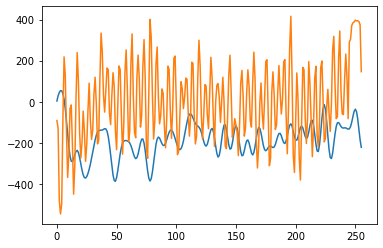

In [26]:
ds = 4 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [7,10,12]
fs_synth = 256
fs = int(fs_synth/ds)
over_n_seconds = 4
number_of_samples = fs*over_n_seconds
number_of_train = 4
removeDC = True
applyFilter = True
synth_power = 0
synth_noise = 0

data_file_7 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\Proper_Gain_255\7hz_2.txt")
print(min(data_file_7),max(data_file_7))
values_7 = prepare_data(data_file_7, 7, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)
plt.plot(np.array(data_file_7[:256]) - np.mean(np.array(data_file_7[:256])))

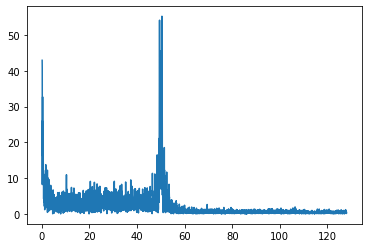

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

fs=256
# Number of samplepoints
N = len(data_file_7)
# sample spacing
T = 1.0 / fs
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

yf = scipy.fftpack.fft(data_file_7)

fig, ax = plt.subplots()
ax.plot(xf[4:], 2.0/N * np.abs(yf[4:N//2]))
plt.show()

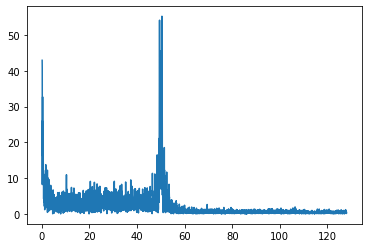

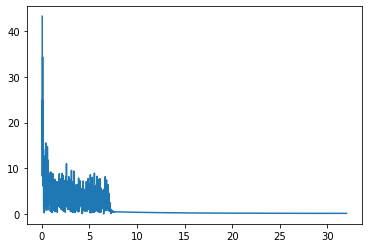

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

fs=256
# Number of samplepoints
N = len(data_file_7)
# sample spacing
T = 1.0 / fs
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

yf = scipy.fftpack.fft(data_file_7)

fig, ax = plt.subplots()
ax.plot(xf[4:], 2.0/N * np.abs(yf[4:N//2]))
plt.show()

filtered = sos_filter_256(data_file_7)

fs=64
# Number of samplepoints
N = len(filtered)
# sample spacing
T = 1.0 / fs
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

yf = scipy.fftpack.fft(filtered)

fig, ax = plt.subplots()
ax.plot(xf[4:], 2.0/N * np.abs(yf[4:N//2]))
plt.show()

832 2289
downsampling 7424
to 1856
-29.17 29.646
downsampling 7168
to 1792
-27.109 23.95
downsampling 7168
to 1792
(1, 256, 7) (1, 256, 7) (1, 256, 7)
(3, 1, 256, 7)
35
(array([4, 5, 6]), array([0, 1, 2, 3]))
GCCA Total Average Accuracy: 0.5555555555555555
MsetCCA Total Average Accuracy: 0.4444444444444444
GCCA 7hz accuracy:0.6666666666666666
GCCA 10hz accuracy:1.0
GCCA 12hz accuracy:0.0
MsetCCA 7hz accuracy:1.0
MsetCCA 10hz accuracy:0.3333333333333333
MsetCCA 12hz accuracy:0.0


(0.5555555555555555,
 0.4444444444444444,
 [0.6666666666666666, 1.0, 0.0],
 [1.0, 0.3333333333333333, 0.0])

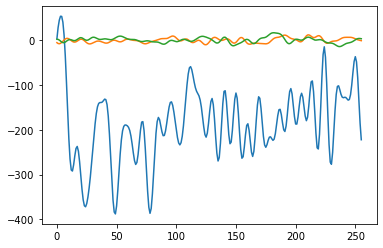

In [78]:
ds = 4 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [7,10,12]
fs_synth = 256
fs = int(fs_synth/ds)
over_n_seconds = 4
number_of_samples = fs*over_n_seconds
number_of_train = 4
removeDC = True
applyFilter = True
synth_power = 0
synth_noise = 0

# data_file_7 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\Proper_Gain_255\7hz_2.txt")
data_file_7 = load_array_data("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/Proper_Gain_255/7hz_2.txt")
print(min(data_file_7),max(data_file_7))
values_7 = prepare_data(data_file_7, 7, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

# data_file_10 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\Proper_Gain_255\10hz_2.txt")
data_file_7 = load_array_data("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/Proper_Gain_255/10hz_2.txt")
print(min(data_file_10),max(data_file_10))
values_10 = prepare_data(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

# data_file_12 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\Proper_Gain_255\12hz_2.txt")
data_file_7 = load_array_data("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/Proper_Gain_255/12hz_2.txt")
print(min(data_file_12),max(data_file_12))
values_12 = prepare_data(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

print(values_12.shape, values_10.shape, values_7.shape)

data_packed = np.array([values_7, values_10, values_12])

print(data_packed.shape)

train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
print(len(train_test_idxs))
print((train_test_idxs[0]))
test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)

downsampling 7424
to 1856
downsampling 7424
to 1856
downsampling 7424
to 1856
(1, 256, 7) (1, 256, 7) (1, 256, 7)
(3, 1, 256, 7)
35
(array([4, 5, 6]), array([0, 1, 2, 3]))
GCCA Total Average Accuracy: 0.5555555555555555
MsetCCA Total Average Accuracy: 0.4444444444444444
GCCA 7hz accuracy:0.6666666666666666
GCCA 10hz accuracy:0.6666666666666666
GCCA 12hz accuracy:0.3333333333333333
MsetCCA 7hz accuracy:0.3333333333333333
MsetCCA 10hz accuracy:0.6666666666666666
MsetCCA 12hz accuracy:0.3333333333333333


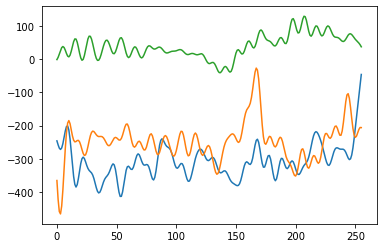

In [30]:
ds = 4 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [7,10,12]
fs_synth = 256
fs = int(fs_synth/ds)
over_n_seconds = 4
number_of_samples = fs*over_n_seconds
number_of_train = 4
removeDC = True
applyFilter = True
synth_power = 0
synth_noise = 0

data_file_7 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fullscreen_256\7red1.txt")
# data_file_7 = data_file_7[:1024] + data_file_7[2048:]#data_file_7[3072:]
values_7 = prepare_data(data_file_7, 7, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

data_file_10 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fullscreen_256\10hzred.txt")
# data_file_10 = data_file_10[:1024] + data_file_10[2048:]#data_file_10[3072:]
values_10 = prepare_data(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

data_file_12 = load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fullscreen_256\12hzred.txt")
# data_file_12 = data_file_12[:1024] + data_file_12[2048:]#data_file_12[3072:]
values_12 = prepare_data(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

print(values_12.shape, values_10.shape, values_7.shape)

data_packed = np.array([values_7, values_10, values_12])

print(data_packed.shape)

train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
print(len(train_test_idxs))
print((train_test_idxs[0]))
test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)

In [32]:
ds = 1 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [8.57,10,12,15]
fs_synth = 256
fs = fs_synth/ds
number_of_samples = 256
number_of_train = 4
removeDC = False
applyFilter = False
synth_power = 0
synth_noise = 0

df = pd.read_csv(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\online_dataset\data\subject11.csv",sep=';')
s1_8_57 = standardise(df['F1'].to_numpy())
s1_8_57 = prepare_data(s1_8_57, 8.57, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

s1_10 = standardise(df['F2'].to_numpy())
s1_10 = prepare_data(s1_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

s1_12 = standardise(df['F3'].to_numpy())
s1_12 = prepare_data(s1_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

s1_15 = standardise(df['F4'].to_numpy())
s1_15 = prepare_data(s1_15, 15, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

print(s1_15.shape, s1_12.shape, s1_10.shape, s1_8_57.shape)

data_packed = np.array([s1_8_57, s1_10, s1_12, s1_15])

print(data_packed.shape)

train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
print(len(train_test_idxs))
test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)


(4096,)
(4096,)
(4096,)
(4096,)
(1, 256, 16) (1, 256, 16) (1, 256, 16) (1, 256, 16)
(4, 1, 256, 16)
1820
GCCA Total Average Accuracy: 0.1875
MsetCCA Total Average Accuracy: 0.16666666666666669
GCCA 8.57hz accuracy:0.4166666666666667
GCCA 10hz accuracy:0.08333333333333333
GCCA 12hz accuracy:0.08333333333333333
GCCA 15hz accuracy:0.16666666666666666
MsetCCA 8.57hz accuracy:0.4166666666666667
MsetCCA 10hz accuracy:0.16666666666666666
MsetCCA 12hz accuracy:0.08333333333333333
MsetCCA 15hz accuracy:0.0


In [80]:
ds = 1 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [7,10,12]
fs_synth = 64
fs = 64
over_n_seconds = 1
number_of_samples = fs*over_n_seconds
number_of_train = 4
removeDC = False
applyFilter = False
synth_power = 0
synth_noise = 0

data_file_all = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/livedata/on_board_downsample_filter1/decoding_data.txt")
test_7 = data_file_all[:256*10]
test_10 = data_file_all[256*10:256*20]
test_12 = data_file_all[256*20:256*30]

print(len(test_7),len(test_10),len(test_12))

train_7 = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/livedata/on_board_downsample_filter1/7hz_calibration.txt")
train_10 = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/livedata/on_board_downsample_filter1/10hz_calibration.txt")
train_12 = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/livedata/on_board_downsample_filter1/12hz_calibration.txt")
# train_12 = load_array_data_float(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\livedata\on_board_downsample_filter1\12hz_calibration.txt")

print(len(train_7),len(train_10),len(train_12))

data_file_7 = flatten([train_7, test_7])
data_file_10 = flatten([train_10, test_10])
data_file_12 = flatten([train_12, test_12])

values_7 = prepare_data(data_file_7, 7, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)
values_10 = prepare_data(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)
values_12 = prepare_data(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

print(values_12.shape, values_10.shape, values_7.shape)

data_packed = np.array([values_7, values_10, values_12])

print(data_packed.shape)

train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
print(len(train_test_idxs))
print((train_test_idxs[0]))
test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)

2560 2560 2560
1024 1024 1024
(1, 64, 56) (1, 64, 56) (1, 64, 56)
(3, 1, 64, 56)
367290
(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55]), array([0, 1, 2, 3]))
GCCA Total Average Accuracy: 0.2884615384615385
MsetCCA Total Average Accuracy: 0.23076923076923075
GCCA 7hz accuracy:0.19230769230769232
GCCA 10hz accuracy:0.38461538461538464
GCCA 12hz accuracy:0.28846153846153844
MsetCCA 7hz accuracy:0.17307692307692307
MsetCCA 10hz accuracy:0.19230769230769232
MsetCCA 12hz accuracy:0.3269230769230769


(0.2884615384615385,
 0.23076923076923075,
 [0.19230769230769232, 0.38461538461538464, 0.28846153846153844],
 [0.17307692307692307, 0.19230769230769232, 0.3269230769230769])

### Online Dataset

In [76]:
import random

ds = 1 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [8,10,12]
fs_synth = 250
fs = int(fs_synth/ds)
over_n_seconds = 1
number_of_samples = fs*over_n_seconds
number_of_train = 4
removeDC = False
applyFilter = False
synth_power = 0
synth_noise = 0

gcca_arr = []
mset_arr = []
gcca_f = []
mset_f = []

blocks = [i for i in range(1,7)]
# random.shuffle(blocks)
print(blocks)
for channel in range(1,10):
    data_file_7 = []
#     for block in range(1,7):
    for block in blocks:
        data_file_7 += load_array_data_online("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/mnakanishi/8hz/8hz_channel_0{c}_0{b}".format(c=channel,b=block))                                       
    values_7 = prepare_data(data_file_7, 8, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

    data_file_10 = []
#     for block in range(1,7):
    for block in blocks:
        data_file_10 += load_array_data_online("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/mnakanishi/10hz/10hz_channel_0{c}_0{b}".format(c=channel,b=block))
    values_10 = prepare_data(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

    data_file_12 = []
#     for block in range(1,7):
    for block in blocks:
        data_file_12 += load_array_data_online("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/mnakanishi/12hz/12hz_channel_0{c}_0{b}".format(c=channel,b=block))
    values_12 = prepare_data(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

    print(values_12.shape, values_10.shape, values_7.shape)

    data_packed = np.array([values_7, values_10, values_12])

    print(data_packed.shape)

    train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
    print(len(train_test_idxs))
    print((train_test_idxs[0]))
    gcca, mset, gccaf, msetf = test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)
    gcca_arr.append(gcca)
    mset_arr.append(mset)
    gcca_f.append(gccaf)
    mset_f.append(msetf)

[1, 2, 3, 4, 5, 6]
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
27405
(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29]), array([0, 1, 2, 3]))
GCCA Total Average Accuracy: 0.4871794871794872
MsetCCA Total Average Accuracy: 0.5512820512820512
GCCA 8hz accuracy:0.46153846153846156
GCCA 10hz accuracy:0.46153846153846156
GCCA 12hz accuracy:0.5384615384615384
MsetCCA 8hz accuracy:0.5384615384615384
MsetCCA 10hz accuracy:0.6538461538461539
MsetCCA 12hz accuracy:0.46153846153846156
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
27405
(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29]), array([0, 1, 2, 3]))
GCCA Total Average Accuracy: 0.6794871794871794
MsetCCA Total Average Accuracy: 0.5384615384615384
GCCA 8hz accuracy:0.8461538461538461
GCCA 10hz accuracy:0.6923076923076923
GCCA 12hz accuracy:0.5
MsetCCA 8hz accuracy:0.46153846153846156


In [75]:
print(sum(gcca_arr)/len(gcca_arr))
print(gcca_arr)
print(sum(mset_arr)/len(mset_arr))
print(mset_arr)

0.6381766381766381
[0.4871794871794872, 0.6794871794871794, 0.7051282051282052, 0.6666666666666666, 0.641025641025641, 0.5128205128205129, 0.7051282051282052, 0.7692307692307692, 0.576923076923077]
0.574074074074074
[0.5512820512820512, 0.5384615384615384, 0.5256410256410257, 0.6923076923076924, 0.5256410256410257, 0.3846153846153846, 0.5641025641025641, 0.7564102564102564, 0.6282051282051282]


# Filtering tests

In [ ]:
fs = 512
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 50 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)

sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

filtered = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, data_file_7[:512])
# filtered = signal.sosfilt(sos_ellip, data_file_7[:256])

plt.plot(filtered)

In [ ]:
data_file_7_plot = data_file_7 - sum(data_file_7)/len(data_file_7)
plt.plot(data_file_7_plot)

In [ ]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [ ]:
filter_butter = butter_bandpass_filter(data_file_7_plot, 4, 28, 256, order=10)
plt.plot(filter_butter)

In [ ]:
plt.plot(load_array_data(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED2.txt"))

In [ ]:
test = [1171, 1271, 1424, 1235, 999, 960, 1205, 1424, 1319, 1071, 999, 1219, 1466, 1392, 1148, 993, 1181, 1411, 1393, 1159, 999, 1174, 1409, 1435, 1205, 1013, 1165, 1424, 1488, 1266, 1052, 1149, 1412, 1522, 1323, 1078, 1107, 1573, 1595, 1405, 1203, 1184, 1367, 1552, 1424, 1200, 1119, 1344, 1533, 1453, 1242, 1135, 1419, 1533, 1462, 1201, 1062, 1253, 1447, 1419, 1166, 1005, 1200, 1468, 1520, 1281, 1085, 1261, 1445, 1535, 1296, 1072, 1131, 1381, 1503, 1312, 1091, 1109, 1353, 1509, 1343, 1089, 1067, 1301, 1479, 1354, 1109, 1022, 1233, 1454, 1366, 1125, 976, 1289, 1411, 1399, 1191, 1043, 1213, 1459, 1476, 1254, 1066, 1213, 1461, 1510, 1261, 1039, 1108, 1368, 1491, 1311, 1094, 1126, 1338, 1498, 1269, 1123, 1118, 1328, 1473, 1326, 1089, 1058, 1296, 1478, 1373, 1136, 1043, 1287, 1543, 1479, 1200, 1061, 1234, 1462, 1466, 1200, 998, 1130, 1360, 1398, 1185, 976, 1104, 1335, 1418, 1207, 978, 1071, 1296, 1439, 1249, 1013, 1045, 1281, 1426, 1278, 1047, 1018, 1263, 1437, 1337, 1136, 1065, 1302, 1490, 1419, 1187, 1086, 1289, 1509, 1410, 1189, 1009, 1184, 1401, 1397, 1166, 999, 1155, 1406, 1456, 1248, 1046, 1159, 1394, 1462, 1248, 1035, 1138, 1403, 1533, 1319, 1085, 1074, 1281, 1433, 1152, 1040, 974, 1213, 1406, 1313, 1063, 993, 1243, 1507, 1443, 1165, 1008, 1200, 1472, 1465, 1198, 993, 1130, 1388, 1469, 1264, 1065, 1146, 1356, 1472, 1255, 1090, 1171, 1390, 1475, 1264, 1031, 1102, 1349, 1511, 1328, 1092, 1116, 1378, 1557, 1406, 1138, 1047, 1519, 1618, 1534, 1318, 1243, 1259, 1328, 1365, 1377, 1396, 1408, 1419, 1456, 1520, 1184, 1395, 1445, 1431, 1226, 1117, 1290, 1463, 1380, 1155, 1049, 1271, 1501, 1466, 1232, 1047, 1372, 1479, 1450, 1215, 1002, 1168, 1419, 1485, 1260, 1023, 1104, 1330, 1425, 1221, 1021, 1099, 1335, 1502, 1353, 1149, 1136, 1344, 1502, 1337, 1103, 1082, 1279, 1461, 1338, 1087, 1005, 1232, 1456, 1409, 1181, 1050, 1255, 1488, 1471, 1222, 1065, 1227, 1487, 1520, 1309, 1104, 1216, 1433, 1527, 1315, 1111, 1157, 1387, 1481, 1291, 1063, 1089, 1347, 1525, 1377, 1169, 1158, 1397, 1585, 1459, 1232, 1168, 1367, 1578, 1488, 1261, 1125, 1291, 1482, 1429, 1221, 1098, 1285, 1518, 1487, 1253, 1015, 1161, 1413, 1491, 1287, 1047, 1118, 1370, 1482, 1303, 1118, 1198, 1467, 1613, 1391, 1104, 1103, 1365, 1582, 1438, 1215, 1136, 1345, 1547, 1358, 1186, 1102, 1323, 1533, 1462, 1199, 1039, 1223, 1445, 1445, 1226, 1069, 1220, 1445, 1473, 1234, 1009, 1113, 1344, 1424, 1233, 1045, 1143, 1401, 1551, 1221, 1119, 1124, 1322, 1477, 1334, 1169, 1198, 1424, 1579, 1446, 1168, 1104, 1361, 1564, 1475, 1217, 1103, 1309, 1531, 1473, 1227, 1057, 1239, 1474, 1474, 1247, 1046, 1189, 1411, 1474, 1279, 1104, 1223, 1427, 1517, 1295, 1078, 1152, 1417, 1532, 1354, 1138, 1138, 1349, 1493, 1328, 1110, 1102, 1324, 1513, 1392, 1161, 1097, 1315, 1530, 1435, 1162, 1280, 1314, 1573, 1609, 1360, 1136, 1281, 1531, 1568, 1329, 1125, 1242, 1456, 1496, 1279, 1090, 1201, 1455, 1570, 1349, 1131, 1200, 1434, 1595, 1414, 1187, 1166, 1394, 1559, 1395, 1157, 1086, 1345, 1600, 1491, 1263, 1137, 1344, 1562, 1532, 1595, 1600, 1618, 1615, 1613, 1601, 1593, 1584, 1499, 1485, 1222, 1189, 1435, 1591, 1408, 1182, 1168, 1399, 1599, 1484, 1267, 1193, 1418, 1616, 1441, 1289, 1167, 1358, 1559, 1475, 1259, 1121, 1332, 1610, 1614, 1382, 1189, 1323, 1551, 1588, 1346, 1142, 1269, 1501, 1587, 1360, 1117, 1183, 1423, 1589, 1289, 1159, 1191, 1465, 1644, 1498, 1229, 1187, 1407, 1638, 1533, 1273, 1174, 1391, 1593, 1550, 1312, 1168, 1370, 1593, 1575, 1341, 1184, 1373, 1633, 1648, 1392, 1154, 1275, 1505, 1584, 1397, 1227, 1299, 1559, 1625, 1398, 1168, 1220, 1498, 1634, 1472, 1228, 1218, 1461, 1643, 1470, 1232, 1174, 1424, 1641, 1510, 1253, 1116, 1313, 1535, 1514, 1297, 1157, 1339, 1570, 1533, 1307, 1137, 1280, 1549, 1564, 1357, 1136, 1257, 1493, 1591, 1380, 1152, 1202, 1438, 1552, 1393, 1147, 1216, 1407, 1549, 1372, 1143, 1141, 1390, 1555, 1403, 1168, 1116, 1360, 1595, 1488, 1233, 1117, 1361, 1611, 1580, 1308, 1134, 1311, 1566, 1584, 1339, 1133, 1349, 1503, 1587, 1380, 1180, 1289, 1511, 1614, 1424, 1183, 1250, 1472, 1607, 1447, 1212, 1187, 1424, 1600, 1455, 1207, 1161, 1382, 1583, 1479, 1221, 1121, 1432, 1511, 1434, 1183, 1055, 1321, 1584, 1595, 1334, 1105, 1264, 1520, 1594, 1391, 1173, 1264, 1483, 1589, 1392, 1177, 1232, 1470, 1607, 1417, 1174, 1201, 1437, 1595, 1430, 1183, 1152, 1381, 1610, 1500, 1282, 1203, 1401, 1628, 1561, 1307, 1203, 1386, 1593, 1546, 1314, 1136, 1335, 1562, 1534, 1328, 1153, 1315, 1570, 1573, 1372, 1191, 1305, 1558, 1648, 1413, 1179, 1207, 1429, 1552, 1358, 1129, 1159, 1437, 1618, 1469, 1216, 1155, 1394, 1607, 1515, 1402, 1416, 1504, 1552, 1557, 1583, 1595, 1603, 1621, 1636, 1490, 1354, 1152, 1260, 1483, 1594, 1381, 1161, 1210, 1468, 1616, 1422, 1146, 1149, 1356, 1527, 1408, 1181, 1150, 1387, 1600, 1501, 1241, 1136, 1328, 1558, 1522, 1299, 1152, 1324, 1520, 1518, 1299, 1151, 1298, 1524, 1553, 1351, 1156, 1345, 1515, 1616, 1381, 1175, 1232, 1461, 1585, 1381, 1142, 1163, 1392, 1570, 1423, 1206, 1199, 1462, 1649, 1526, 1271, 1168, 1367, 1580, 1505, 1294, 1155, 1441, 1535, 1494, 1275, 1134, 1338, 1553, 1552, 1317, 1134, 1303, 1569, 1640, 1402, 1230, 1328, 1562, 1643, 1391, 1147, 1225, 1469, 1630, 1430, 1181, 1177, 1411, 1605, 1456, 1217, 1169, 1402, 1616, 1506, 1265, 1169, 1407, 1631, 1581, 1326, 1194, 1374, 1573, 1510, 1270, 1123, 1341, 1600, 1617, 1343, 1129, 1257, 1522, 1616, 1419, 1193, 1242, 1489, 1600, 1392, 1168, 1199, 1451, 1631, 1488, 1258, 1258, 1483, 1653, 1509, 1270, 1191, 1403, 1584, 1507, 1280, 1189, 1402, 1616, 1525, 1317, 1152, 1341, 1570, 1550, 1292, 1115, 1288, 1549, 1634, 1422, 1195, 1313, 1535, 1630, 1443, 1227, 1289, 1513, 1628, 1438, 1187, 1183, 1394, 1571, 1325, 1171, 1157, 1399, 1612, 1514, 1289, 1223, 1442, 1626, 1510, 1273, 1204, 1392, 1620, 1581, 1318, 1136, 1302, 1552, 1583, 1360, 1169, 1306, 1529, 1616, 1270, 1187, 1311, 1550, 1668, 1456, 1195, 1258, 1495, 1682, 1517, 1283, 1269, 1502, 1659, 1490, 1259, 1207, 1442, 1649, 1571, 1339, 1232, 1474, 1689, 1630, 1366, 1189, 1360, 1588, 1600, 1378, 1223, 1420, 1683, 1717, 1456, 1221, 1309, 1583, 1667, 1514, 1293, 1332, 1520, 1631, 1443, 1226, 1280, 1543, 1735, 1168, 1165, 1161, 1175, 1183, 1200, 1211, 1217, 1255, 1489, 1368, 1583, 1595, 1361, 1168, 1328, 1562, 1631, 1406, 1165, 1264, 1513, 1618, 1424, 1188, 1226, 1476, 1629, 1451, 1227, 1250, 1511, 1694, 1553, 1296, 1250, 1483, 1659, 1517, 1271, 1195, 1439, 1666, 1603, 1330, 1173, 1359, 1597, 1567, 1378, 1211, 1389, 1617, 1648, 1429, 1258, 1397, 1634, 1705, 1451, 1233, 1321, 1552, 1665, 1467, 1232, 1265, 1500, 1654, 1462, 1232, 1218, 1473, 1686, 1495, 1296, 1225, 1444, 1686, 1585, 1332, 1206, 1423, 1684, 1649, 1419, 1270, 1457, 1744, 1757, 1547, 1320, 1466, 1664, 1731, 1487, 1252, 1359, 1600, 1696, 1505, 1259, 1360, 1621, 1763, 1555, 1285, 1282, 1535, 1738, 1597, 1339, 1270, 1514, 1709, 1607, 1368, 1271, 1502, 1719, 1667, 1392, 1248, 1437, 1680, 1696, 1473, 1279, 1407, 1632, 1664, 1462, 1280, 1417, 1623, 1694, 1465, 1253, 1353, 1613, 1711, 1513, 1271, 1309, 1520, 1669, 1471, 1249, 1264, 1535, 1746, 1600, 1318, 1246, 1475, 1709, 1631, 1370, 1227, 1407, 1633, 1607, 1408, 1263, 1453, 1685, 1691, 1490, 1320, 1470, 1679, 1685, 1450, 1254, 1377, 1633, 1728, 1494, 1275, 1407, 1622, 1766, 1586, 1296, 1264, 1492, 1687, 1556, 1322, 1265, 1478, 1670, 1558, 1339, 1261, 1477, 1675, 1594, 1377, 1250, 1441, 1657, 1602, 1363, 1233, 1527, 1688, 1700, 1450, 1229, 1349, 1584, 1669, 1446, 1232, 1319, 1584, 1697, 1565, 1334, 1338, 1546, 1702, 1550, 1343, 1360, 1600, 1759, 1588, 1339, 1276, 1654, 1725, 1631, 1375, 1249, 1479, 1709, 1674, 1429, 1261, 1456, 1693, 1680, 1419, 1242, 1375, 1616, 1653, 1441, 1253, 1378, 1633, 1724, 1506, 1263, 1744, 1745, 1741, 1722, 1715, 1702, 1687, 1680, 1642, 1459, 1168, 1351, 1575, 1547, 1300, 1136, 1322, 1561, 1587, 1267, 1225, 1375, 1594, 1626, 1379, 1168, 1271, 1521, 1651, 1461, 1217, 1248, 1456, 1601, 1456, 1245, 1243, 1476, 1647, 1535, 1327, 1267, 1488, 1687, 1574, 1328, 1227, 1424, 1647, 1601, 1358, 1219, 1449, 1695, 1680, 1409, 1189, 1332, 1603, 1643, 1430, 1233, 1355, 1605, 1705, 1468, 1220, 1282, 1523, 1679, 1500, 1251, 1286, 1467, 1626, 1473, 1248, 1228, 1471, 1658, 1557, 1331, 1264, 1469, 1657, 1573, 1377, 1271, 1465, 1628, 1535, 1295, 1165, 1408, 1647, 1664, 1424, 1239, 1484, 1654, 1709, 1443, 1223, 1335, 1589, 1709, 1499, 1266, 1318, 1556, 1713, 1568, 1325, 1278, 1489, 1669, 1546, 1315, 1280, 1494, 1710, 1619, 1363, 1254, 1572, 1664, 1603, 1379, 1221, 1415, 1648, 1647, 1424, 1247, 1385, 1631, 1677, 1439, 1265, 1373, 1610, 1698, 1515, 1324, 1391, 1595, 1705, 1488, 1275, 1308, 1549, 1697, 1494, 1299, 1264, 1508, 1709, 1584, 1310, 1215, 1406, 1633, 1599, 1350, 1239, 1431, 1647, 1627, 1381, 1228, 1406, 1634, 1638, 1392, 1226, 1390, 1626, 1699, 1487, 1284, 1394, 1633, 1727, 1505, 1291, 1353, 1597, 1731, 1552, 1309, 1327, 1534, 1664, 1490, 1241, 1216, 1472, 1704, 1583, 1315, 1229, 1456, 1690, 1604, 1390, 1238, 1466, 1702, 1673, 1424, 1222, 1395, 1635, 1680, 1471, 1263, 1393, 1631, 1703, 1502, 1279, 1351, 1593, 1712, 1505, 1285, 1299, 1572, 1744, 1503, 1339, 1280, 1475, 1678, 1580, 1354, 1296, 1519, 1730, 1654, 1415, 1315, 1472, 1659, 1618, 1367, 1216, 1404, 1622, 1616, 1383, 1179, 1344, 1586, 1632, 1232, 1446, 1455, 1532, 1575, 1584, 1605, 1618, 1630, 1664, 1696, 1665, 1424, 1309, 1486, 1669, 1610, 1405, 1296, 1595, 1682, 1634, 1390, 1217, 1403, 1637, 1655, 1421, 1218, 1344, 1639, 1712, 1534, 1311, 1339, 1533, 1661, 1488, 1270, 1289, 1511, 1664, 1502, 1257, 1233, 1452, 1627, 1503, 1275, 1246, 1493, 1700, 1611, 1340, 1205, 1408, 1648, 1625, 1370, 1233, 1418, 1636, 1659, 1450, 1284, 1421, 1673, 1685, 1450, 1232, 1347, 1598, 1687, 1489, 1247, 1323, 1575, 1744, 1583, 1311, 1305, 1526, 1699, 1579, 1371, 1363, 1571, 1741, 1606, 1354, 1298, 1530, 1761, 1679, 1425, 1264, 1438, 1670, 1651, 1452, 1285, 1461, 1690, 1701, 1461, 1281, 1417, 1712, 1809, 1603, 1355, 1426, 1655, 1738, 1543, 1312, 1355, 1603, 1763, 1570, 1336, 1313, 1552, 1734, 1529, 1335, 1253, 1490, 1728, 1655, 1403, 1243, 1427, 1661, 1657, 1449, 1287, 1433, 1651, 1673, 1439, 1259, 1397, 1625, 1701, 1472, 1284, 1401, 1664, 1791, 1486, 1360, 1388, 1613, 1759, 1585, 1333, 1326, 1574, 1780, 1698, 1439, 1371, 1578, 1751, 1681, 1444, 1338, 1526, 1726, 1666, 1425, 1267, 1471, 1731, 1726, 1490, 1299, 1467, 1712, 1759, 1544, 1344, 1477, 1712, 1781, 1580, 1360, 1424, 1696, 1794, 1577, 1344, 1360, 1601, 1776, 1622, 1379, 1348, 1581, 1776, 1663, 1428, 1349, 1549, 1737, 1663, 1437, 1309, 1509, 1730, 1711, 1467, 1278, 1427, 1647, 1658, 1445, 1281, 1409, 1637, 1689, 1478, 1264, 1365, 1609, 1734, 1554, 1354, 1445, 1647, 1789, 1617, 1362, 1349, 1583, 1759, 1625, 1372, 1327, 1519, 1712, 1611, 1406, 1328, 1550, 1744, 1661, 1388, 1247, 1454, 1712, 1713, 1473, 1266, 1495, 1678, 1382, 1372, 1319, 1300, 1298, 1293, 1287, 1284, 1291, 1487, 1589, 1765, 1614, 1345, 1282, 1516, 1728, 1584, 1399, 1291, 1517, 1743, 1701, 1455, 1268, 1463, 1696, 1727, 1534, 1385, 1507, 1727, 1731, 1488, 1269, 1382, 1628, 1707, 1489, 1255, 1315, 1572, 1729, 1442, 1318, 1330, 1582, 1775, 1623, 1362, 1296, 1498, 1697, 1603, 1374, 1264, 1488, 1687, 1638, 1409, 1263, 1449, 1653, 1653, 1433, 1291, 1461, 1685, 1695, 1491, 1295, 1422, 1620, 1655, 1425, 1219, 1328, 1610, 1761, 1584, 1346, 1356, 1564, 1683, 1522, 1338, 1335, 1584, 1742, 1600, 1366, 1328, 1554, 1745, 1635, 1383, 1296, 1505, 1739, 1690, 1472, 1315, 1507, 1744, 1756, 1535, 1334, 1485, 1765, 1807, 1591, 1334, 1377, 1616, 1734, 1558, 1347, 1395, 1630, 1791, 1611, 1387, 1392, 1617, 1790, 1652, 1392, 1324, 1530, 1743, 1648, 1410, 1307, 1547, 1783, 1708, 1462, 1310, 1479, 1715, 1724, 1498, 1309, 1486, 1725, 1754, 1522, 1328, 1518, 1698, 1781, 1585, 1323, 1399, 1634, 1754, 1565, 1331, 1361, 1620, 1791, 1644, 1407, 1389, 1614, 1807, 1680, 1444, 1385, 1608, 1827, 1766, 1535, 1406, 1694, 1759, 1687, 1437, 1295, 1488, 1743, 1763, 1559, 1360, 1483, 1714, 1773, 1547, 1333, 1417, 1623, 1744, 1558, 1359, 1438, 1653, 1774, 1573, 1328, 1355, 1619, 1813, 1646, 1406, 1326, 1554, 1795, 1711, 1475, 1343, 1521, 1758, 1714, 1463, 1296, 1443, 1661, 1689, 1497, 1360, 1510, 1738, 1762, 1500, 1280, 1365, 1631, 1743, 1560, 1351, 1407, 1633, 1766, 1602, 1382, 1392, 1605, 1739, 1584, 1324, 1313, 1574, 1786, 1659, 1401, 1297, 1505, 1719, 1658, 1414, 1286, 1498, 1728, 1687, 1495, 1343, 1730, 1739, 1762, 1749, 1747, 1735, 1727, 1718, 1654, 1458, 1361, 1375, 1619, 1808, 1618, 1370, 1314, 1519, 1722, 1629, 1409, 1299, 1518, 1731, 1680, 1443, 1295, 1491, 1702, 1677, 1427, 1233, 1363, 1611, 1641, 1435, 1246, 1381, 1626, 1713, 1520, 1315, 1426, 1605, 1707, 1495, 1288, 1334, 1596, 1793, 1644, 1423, 1363, 1593, 1782, 1662, 1424, 1329, 1526, 1769, 1700, 1471, 1318, 1489, 1695, 1697, 1499, 1354, 1680, 1791, 1798, 1587, 1363, 1473, 1696, 1750, 1545, 1341, 1462, 1699, 1790, 1533, 1315, 1328, 1582, 1743, 1581, 1365, 1380, 1605, 1779, 1646, 1413, 1363, 1562, 1732, 1603, 1363, 1264, 1500, 1743, 1710, 1493, 1343, 1514, 1703, 1678, 1424, 1266, 1450, 1675, 1717, 1497, 1318, 1460, 1697, 1751, 1550, 1328, 1417, 1676, 1780, 1592, 1331, 1360, 1623, 1795, 1653, 1392, 1334, 1556, 1744, 1647, 1392, 1361, 1569, 1776, 1680, 1427, 1290, 1511, 1747, 1713, 1474, 1291, 1461, 1691, 1702, 1503, 1327, 1465, 1702, 1757, 1543, 1329, 1426, 1664, 1787, 1590, 1357, 1415, 1637, 1765, 1586, 1355, 1351, 1580, 1751, 1635, 1409, 1378, 1619, 1829, 1615, 1407, 1265, 1484, 1754, 1743, 1508, 1328, 1533, 1781, 1778, 1568, 1381, 1535, 1772, 1827, 1585, 1349, 1459, 1693, 1806, 1591, 1374, 1445, 1664, 1787, 1447, 1329, 1360, 1613, 1775, 1635, 1391, 1332, 1559, 1743, 1611, 1363, 1264, 1510, 1732, 1683, 1455, 1311, 1503, 1710, 1662, 1455, 1309, 1519, 1764, 1818, 1601, 1355, 1463, 1647, 1692, 1488, 1307, 1415, 1649, 1759, 1520, 1280, 1335, 1648, 1831, 1677, 1421, 1341, 1520, 1681, 1567, 1346, 1323, 1553, 1749, 1645, 1409, 1293, 1482, 1710, 1675, 1382, 1392, 1447, 1483, 1490, 1515, 1524, 1533, 1583, 1793, 1825, 1635, 1391, 1394, 1644, 1830, 1665, 1411, 1356, 1593, 1807, 1734, 1493, 1401, 1616, 1808, 1773, 1524, 1415, 1568, 1797, 1776, 1583, 1456, 1643, 1901, 1914, 1671, 1456, 1520, 1738, 1776, 1578, 1365, 1455, 1711, 1861, 1691, 1461, 1474, 1670, 1823, 1674, 1431, 1426, 1641, 1814, 1703, 1498, 1459, 1698, 1889, 1795, 1552, 1418, 1614, 1840, 1779, 1563, 1424, 1623, 1846, 1856, 1579, 1361, 1508, 1778, 1844, 1638, 1367, 1467, 1719, 1823, 1605, 1357, 1415, 1682, 1877, 1730, 1495, 1467, 1667, 1837, 1712, 1456, 1463, 1680, 1863, 1755, 1513, 1401, 1648, 1859, 1816, 1586, 1413, 1619, 1810, 1809, 1584, 1406, 1577, 1806, 1815, 1590, 1384, 1471, 1722, 1825, 1616, 1397, 1467, 1673, 1755, 1543, 1331, 1389, 1667, 1835, 1641, 1370, 1311, 1595, 1790, 1710, 1471, 1396, 1596, 1797, 1712, 1470, 1348, 1565, 1817, 1799, 1552, 1379, 1520, 1694, 1713, 1500, 1360, 1535, 1791, 1850, 1633, 1419, 1506, 1759, 1840, 1616, 1382, 1415, 1657, 1822, 1642, 1408, 1402, 1643, 1839, 1711, 1503, 1460, 1690, 1872, 1734, 1488, 1382, 1590, 1805, 1744, 1523, 1422, 1625, 1872, 1820, 1600, 1426, 1594, 1834, 1838, 1594, 1363, 1478, 1732, 1823, 1634, 1407, 1565, 1712, 1824, 1638, 1414, 1447, 1678, 1840, 1680, 1443, 1414, 1621, 1821, 1695, 1469, 1406, 1622, 1815, 1731, 1477, 1321, 1514, 1733, 1709, 1472, 1297, 1577, 1751, 1754, 1522, 1349, 1493, 1713, 1781, 1567, 1359, 1466, 1738, 1859, 1667, 1451, 1506, 1733, 1872, 1703, 1488, 1465, 1680, 1821, 1666, 1451, 1412, 1662, 1843, 1706, 1453, 1360, 1776, 1771, 1713, 1680, 1674, 1652, 1641, 1631, 1600, 1471, 1433, 1833, 1520, 1468, 1493, 1703, 1855, 1690, 1451, 1426, 1647, 1840, 1745, 1553, 1478, 1710, 1868, 1798, 1551, 1387, 1582, 1792, 1801, 1595, 1436, 1623, 1841, 1866, 1635, 1429, 1572, 1840, 1913, 1677, 1391, 1399, 1598, 1717, 1567, 1369, 1421, 1662, 1779, 1583, 1349, 1360, 1600, 1805, 1679, 1424, 1360, 1600, 1815, 1737, 1503, 1409, 1614, 1822, 1775, 1507, 1319, 1495, 1740, 1781, 1593, 1405, 1567, 1793, 1806, 1569, 1339, 1443, 1711, 1825, 1648, 1424, 1456, 1680, 1826, 1665, 1457, 1501, 1643, 1780, 1645, 1450, 1427, 1636, 1808, 1679, 1459, 1409, 1639, 1873, 1791, 1583, 1426, 1603, 1779, 1738, 1515, 1365, 1570, 1782, 1817, 1607, 1438, 1679, 1776, 1841, 1633, 1450, 1521, 1739, 1847, 1649, 1438, 1474, 1706, 1858, 1702, 1492, 1503, 1712, 1888, 1733, 1488, 1425, 1663, 1870, 1776, 1524, 1397, 1607, 1849, 1822, 1438, 1435, 1605, 1805, 1803, 1578, 1429, 1567, 1793, 1823, 1584, 1381, 1482, 1726, 1840, 1679, 1472, 1520, 1722, 1842, 1680, 1469, 1515, 1751, 1903, 1739, 1483, 1424, 1661, 1843, 1751, 1517, 1406, 1606, 1814, 1779, 1522, 1413, 1610, 1823, 1818, 1604, 1423, 1591, 1831, 1872, 1682, 1494, 1644, 1872, 1922, 1687, 1430, 1456, 1653, 1782, 1602, 1420, 1482, 1734, 1894, 1711, 1422, 1409, 1646, 1839, 1737, 1514, 1431, 1648, 1857, 1781, 1533, 1408, 1617, 1843, 1761, 1615, 1424, 1590, 1786, 1805, 1611, 1425, 1559, 1789, 1859, 1658, 1433, 1550, 1756, 1856, 1674, 1448, 1505, 1759, 1929, 1775, 1519, 1473, 1690, 1840, 1584, 1470, 1423, 1645, 1855, 1744, 1533, 1440, 1642, 1659, 1648, 1584, 1551, 1542, 1518, 1503, 1493, 1461, 1424, 1615, 1725, 1872, 1701, 1476, 1471, 1678, 1825, 1695, 1478, 1453, 1648, 1856, 1771, 1590, 1524, 1719, 1877, 1751, 1487, 1354, 1565, 1789, 1805, 1584, 1439, 1774, 1875, 1875, 1632, 1427, 1550, 1786, 1847, 1631, 1425, 1511, 1758, 1856, 1653, 1417, 1442, 1652, 1798, 1614, 1383, 1393, 1644, 1846, 1724, 1470, 1408, 1619, 1840, 1774, 1542, 1436, 1654, 1874, 1847, 1609, 1424, 1579, 1787, 1802, 1582, 1415, 1562, 1766, 1809, 1635, 1455, 1583, 1828, 1934, 1717, 1463, 1485, 1687, 1818, 1647, 1424, 1435, 1675, 1819, 1685, 1460, 1459, 1728, 1934, 1807, 1506, 1406, 1587, 1794, 1739, 1509, 1398, 1622, 1834, 1795, 1578, 1407, 1621, 1840, 1771, 1579, 1350, 1482, 1728, 1795, 1600, 1413, 1544, 1780, 1897, 1667, 1395, 1471, 1715, 1909, 1749, 1524, 1479, 1706, 1869, 1763, 1520, 1415, 1605, 1782, 1642, 1522, 1411, 1591, 1774, 1737, 1522, 1397, 1590, 1787, 1786, 1559, 1421, 1616, 1839, 1899, 1669, 1456, 1547, 1795, 1887, 1671, 1453, 1513, 1732, 1879, 1686, 1417, 1456, 1689, 1855, 1709, 1467, 1414, 1648, 1848, 1742, 1524, 1454, 1698, 1893, 1805, 1565, 1445, 1649, 1874, 1866, 1619, 1424, 1594, 1817, 1845, 1634, 1438, 1581, 1805, 1882, 1680, 1488, 1583, 1806, 1894, 1690, 1482, 1531, 1789, 1907, 1719, 1494, 1467, 1667, 1818, 1690, 1470, 1418, 1670, 1875, 1799, 1577, 1429, 1588, 1796, 1758, 1557, 1421, 1610, 1808, 1820, 1594, 1435, 1580, 1843, 1859, 1666, 1465, 1542, 1749, 1821, 1606, 1393, 1483, 1707, 1838, 1622, 1339, 1401, 1573, 1775, 1648, 1431, 1403, 1648, 1858, 1749, 1498, 1808, 1818, 1881, 1909, 1914, 1927, 1936, 1937, 1943, 1798, 1488, 1731, 1903, 1712, 1398, 1418, 1651, 1827, 1712, 1463, 1405, 1649, 1861, 1776, 1535, 1427, 1642, 1829, 1664, 1556, 1379, 1567, 1799, 1786, 1557, 1360, 1495, 1712, 1774, 1581, 1364, 1494, 1739, 1870, 1679, 1449, 1465, 1671, 1805, 1651, 1463, 1471, 1698, 1842, 1535, 1424, 1418, 1633, 1843, 1718, 1439, 1333, 1555, 1821, 1783, 1574, 1392, 1565, 1758, 1747, 1549, 1378, 1599, 1825, 1853, 1600, 1381, 1499, 1757, 1846, 1654, 1395, 1488, 1744, 1847, 1692, 1453, 1485, 1715, 1875, 1723, 1515, 1488, 1712, 1875, 1747, 1527, 1449, 1680, 1855, 1775, 1571, 1472, 1696, 1891, 1819, 1550, 1398, 1565, 1814, 1843, 1645, 1473, 1616, 1846, 1870, 1697, 1497, 1617, 1873, 1939, 1721, 1474, 1520, 1779, 1916, 1734, 1483, 1453, 1680, 1843, 1734, 1495, 1547, 1725, 1904, 1809, 1568, 1479, 1696, 1914, 1840, 1575, 1395, 1605, 1904, 1893, 1689, 1482, 1618, 1827, 1849, 1620, 1438, 1547, 1797, 1873, 1694, 1488, 1680, 1779, 1878, 1698, 1486, 1547, 1741, 1885, 1705, 1462, 1459, 1705, 1895, 1770, 1567, 1483, 1662, 1840, 1763, 1562, 1487, 1693, 1911, 1873, 1649, 1504, 1660, 1901, 1857, 1626, 1435, 1582, 1822, 1865, 1654, 1426, 1518, 1781, 1903, 1699, 1478, 1490, 1707, 1854, 1697, 1473, 1469, 1725, 1905, 1762, 1507, 1424, 1645, 1858, 1747, 1499, 1383, 1616, 1843, 1803, 1588, 1418, 1595, 1791, 1765, 1534, 1377, 1567, 1783, 1815, 1586, 1392, 1520, 1776, 1847, 1643, 1415, 1459, 1726, 1863, 1712, 1474, 1494, 1697, 1869, 1725, 1504, 1444, 1617, 1771, 1642, 1461, 1429, 1663, 1847, 1754, 1700, 1712, 1787, 1814, 1821, 1836, 1842, 1843, 1859, 1565, 1467, 1713, 1469, 1485, 1699, 1812, 1648, 1442, 1445, 1674, 1886, 1759, 1526, 1457, 1642, 1806, 1712, 1498, 1456, 1643, 1842, 1777, 1552, 1393, 1599, 1839, 1821, 1600, 1418, 1595, 1872, 1866, 1661, 1461, 1579, 1801, 1849, 1636, 1409, 1495, 1744, 1856, 1680, 1459, 1578, 1712, 1856, 1697, 1507, 1521, 1760, 1926, 1761, 1525, 1485, 1731, 1955, 1829, 1565, 1411, 1611, 1821, 1801, 1574, 1421, 1599, 1839, 1866, 1657, 1484, 1745, 1859, 1888, 1680, 1461, 1579, 1783, 1895, 1712, 1495, 1543, 1773, 1910, 1731, 1510, 1477, 1677, 1833, 1706, 1490, 1465, 1699, 1895, 1806, 1586, 1487, 1687, 1906, 1834, 1607, 1435, 1645, 1858, 1843, 1623, 1463, 1639, 1858, 1877, 1629, 1424, 1545, 1784, 1855, 1691, 1483, 1566, 1797, 1927, 1778, 1589, 1616, 1814, 1937, 1797, 1611, 1599, 1807, 1967, 1842, 1655, 1594, 1758, 1889, 1770, 1552, 1488, 1737, 1934, 1862, 1630, 1474, 1654, 1874, 1856, 1629, 1450, 1616, 1853, 1873, 1721, 1507, 1600, 1795, 1856, 1651, 1450, 1519, 1749, 1877, 1700, 1429, 1467, 1700, 1828, 1673, 1472, 1466, 1737, 1930, 1801, 1557, 1451, 1650, 1837, 1680, 1575, 1458, 1627, 1802, 1751, 1567, 1466, 1678, 1893, 1885, 1646, 1457, 1602, 1813, 1872, 1681, 1497, 1604, 1839, 1953, 1744, 1509, 1546, 1767, 1935, 1803, 1530, 1543, 1750, 1918, 1811, 1583, 1495, 1703, 1902, 1830, 1607, 1494, 1695, 1873, 1861, 1677, 1503, 1673, 1852, 1823, 1616, 1472, 1618, 1854, 1887, 1685, 1519, 1635, 1829, 1897, 1682, 1474, 1565, 1826, 1950, 1776, 1543, 1565, 1811, 1987, 1844, 1616, 1583, 1791, 1527, 1520, 1474, 1461, 1457, 1452, 1451, 1453, 1620, 1633, 1734, 1712, 1493, 1589, 1818, 1908, 1723, 1519, 1543, 1745, 1860, 1693, 1488, 1514, 1771, 1931, 1808, 1559, 1488, 1699, 1872, 1786, 1559, 1475, 1699, 1927, 1872, 1620, 1495, 1664, 1879, 1872, 1651, 1466, 1609, 1825, 1831, 1628, 1459, 1603, 1840, 1881, 1674, 1447, 1509, 1749, 1898, 1712, 1483, 1523, 1787, 1952, 1792, 1518, 1502, 1702, 1872, 1778, 1564, 1510, 1701, 1865, 1776, 1552, 1453, 1659, 1870, 1744, 1597, 1434, 1607, 1855, 1889, 1696, 1519, 1633, 1825, 1854, 1648, 1465, 1626, 1872, 1953, 1723, 1461, 1498, 1741, 1883, 1728, 1495, 1492, 1721, 1888, 1779, 1558, 1535, 1741, 1919, 1809, 1574, 1473, 1672, 1871, 1806, 1600, 1490, 1749, 1939, 1919, 1675, 1495, 1667, 1873, 1885, 1654, 1462, 1629, 1870, 1910, 1682, 1443, 1553, 1842, 1999, 1815, 1559, 1552, 1760, 1927, 1786, 1584, 1550, 1762, 1919, 1813, 1617, 1566, 1750, 1904, 1810, 1601, 1522, 1741, 1937, 1872, 1615, 1455, 1630, 1871, 1919, 1734, 1529, 1646, 1855, 1907, 1728, 1519, 1619, 1846, 1893, 1712, 1497, 1549, 1770, 1921, 1743, 1533, 1527, 1741, 1901, 1773, 1562, 1606, 1764, 1930, 1827, 1586, 1466, 1658, 1853, 1808, 1638, 1515, 1728, 1934, 1873, 1651, 1485, 1634, 1844, 1867, 1663, 1497, 1647, 1850, 1885, 1694, 1488, 1721, 1842, 1935, 1712, 1484, 1522, 1755, 1886, 1703, 1456, 1454, 1697, 1897, 1755, 1534, 1467, 1673, 1873, 1778, 1556, 1443, 1648, 1891, 1882, 1681, 1521, 1658, 1861, 1829, 1625, 1440, 1600, 1822, 1869, 1677, 1479, 1596, 1797, 1879, 1680, 1520, 1601, 1838, 1940, 1747, 1527, 1547, 1771, 1739, 1727, 1658, 1616, 1605, 1584, 1567, 1555, 1520, 1477, 1543, 1658, 1871, 1878, 1646, 1453, 1602, 1855, 1941, 1776, 1556, 1639, 1835, 1915, 1751, 1552, 1645, 1862, 2002, 1835, 1595, 1579, 1776, 1935, 1789, 1565, 1522, 1766, 1973, 1898, 1675, 1547, 1712, 1904, 1821, 1618, 1495, 1703, 1937, 1927, 1697, 1477, 1626, 1811, 1852, 1667, 1499, 1627, 1851, 1900, 1689, 1475, 1548, 1782, 1861, 1680, 1463, 1546, 1798, 1951, 1757, 1494, 1479, 1742, 1967, 1856, 1622, 1584, 1733, 1911, 1818, 1577, 1442, 1633, 1853, 1810, 1611, 1440, 1632, 1866, 1861, 1636, 1462, 1599, 1835, 1906, 1728, 1529, 1606, 1786, 1821, 1633, 1456, 1649, 1788, 1895, 1702, 1497, 1549, 1776, 1909, 1734, 1488, 1468, 1726, 1938, 1806, 1570, 1471, 1685, 1911, 1817, 1586, 1431, 1639, 1883, 1872, 1641, 1463, 1616, 1856, 1859, 1621, 1424, 1545, 1793, 1888, 1712, 1503, 1586, 1805, 1920, 1714, 1491, 1507, 1719, 1848, 1689, 1459, 1450, 1673, 1873, 1732, 1509, 1434, 1639, 1851, 1757, 1552, 1468, 1693, 1901, 1853, 1584, 1424, 1633, 1901, 1921, 1685, 1501, 1623, 1833, 1872, 1666, 1456, 1552, 1760, 1871, 1697, 1509, 1567, 1763, 1866, 1702, 1519, 1569, 1798, 1938, 1791, 1557, 1527, 1773, 1983, 1866, 1599, 1479, 1647, 1839, 1776, 1583, 1483, 1711, 1927, 1905, 1691, 1515, 1692, 1897, 1839, 1689, 1518, 1682, 1952, 2022, 1783, 1530, 1591, 1807, 1930, 1744, 1491, 1559, 1773, 1893, 1738, 1499, 1495, 1733, 1936, 1801, 1563, 1454, 1664, 1858, 1707, 1599, 1506, 1707, 1917, 1856, 1639, 1488, 1667, 1858, 1840, 1653, 1486, 1679, 1885, 1909, 1648, 1424, 1499, 1747, 1848, 1698, 1514, 1851, 1856, 1887, 1898, 1898, 1891, 1887, 1882, 1869, 1673, 1451, 1653, 1861, 1767, 1574, 1376, 1522, 1761, 1781, 1595, 1411, 1680, 1767, 1837, 1618, 1446, 1549, 1759, 1841, 1643, 1435, 1520, 1779, 1927, 1727, 1520, 1518, 1742, 1900, 1754, 1494, 1424, 1615, 1799, 1714, 1492, 1424, 1631, 1886, 1830, 1613, 1436, 1598, 1821, 1813, 1599, 1442, 1586, 1826, 1889, 1659, 1457, 1551, 1743, 1823, 1638, 1453, 1534, 1775, 1917, 1726, 1501, 1517, 1742, 1904, 1749, 1515, 1482, 1690, 1877, 1744, 1505, 1425, 1617, 1807, 1748, 1530, 1463, 1712, 1925, 1869, 1616, 1456, 1627, 1861, 1855, 1620, 1438, 1593, 1828, 1840, 1663, 1431, 1520, 1730, 1815, 1623, 1423, 1515, 1798, 1947, 1783, 1498, 1517, 1739, 1909, 1782, 1555, 1508, 1715, 1898, 1795, 1570, 1467, 1654, 1835, 1637, 1511, 1377, 1595, 1808, 1810, 1620, 1473, 1659, 1879, 1921, 1711, 1524, 1673, 1872, 1905, 1696, 1478, 1593, 1843, 1998, 1808, 1557, 1571, 1791, 1947, 1806, 1570, 1552, 1744, 1887, 1755, 1533, 1478, 1703, 1903, 1799, 1573, 1461, 1677, 1878, 1818, 1610, 1467, 1655, 1853, 1838, 1609, 1424, 1579, 1823, 1895, 1693, 1456, 1554, 1786, 1883, 1741, 1535, 1597, 1813, 1895, 1710, 1486, 1527, 1788, 1941, 1783, 1510, 1465, 1671, 1867, 1751, 1520, 1438, 1622, 1808, 1741, 1520, 1447, 1652, 1858, 1825, 1600, 1408, 1581, 1798, 1839, 1638, 1431, 1552, 1772, 1808, 1648, 1477, 1600, 1845, 1953, 1747, 1514, 1520, 1724, 1829, 1645, 1422, 1513, 1751, 1947, 1825, 1596, 1499, 1693, 1859, 1771, 1561, 1473, 1697, 1904, 1809, 1584, 1439, 1680, 1904, 1902, 1676, 1487, 1648, 1872, 1916, 1712, 1652, 1663, 1730, 1767, 1776, 1800, 1811, 1823, 1858, 1855, 1841, 1712, 1513, 1434, 1695, 1893, 1827, 1595, 1458, 1633, 1830, 1735, 1610, 1442, 1616, 1821, 1819, 1611, 1433, 1600, 1840, 1884, 1670, 1439, 1552, 1793, 1920, 1723, 1462, 1494, 1686, 1850, 1722, 1520, 1519, 1701, 1858, 1606, 1520, 1498, 1703, 1883, 1808, 1606, 1529, 1744, 1936, 1859, 1628, 1469, 1677, 1886, 1872, 1651, 1486, 1633, 1824, 1827, 1607, 1424, 1616, 1866, 1963, 1747, 1522, 1609, 1830, 1958, 1789, 1574, 1615, 1818, 1967, 1826, 1616, 1572, 1783, 1936, 1835, 1622, 1570, 1744, 1914, 1827, 1616, 1545, 1758, 1925, 1858, 1598, 1490, 1648, 1887, 1887, 1684, 1504, 1660, 1905, 1937, 1732, 1535, 1629, 1899, 1980, 1797, 1583, 1605, 1809, 1915, 1723, 1509, 1533, 1795, 1984, 1879, 1663, 1632, 1773, 1913, 1802, 1600, 1549, 1734, 1965, 1911, 1705, 1605, 1793, 2000, 1934, 1693, 1520, 1711, 1962, 1987, 1774, 1575, 1680, 1889, 1950, 1737, 1533, 1771, 1919, 2064, 1882, 1646, 1618, 1779, 1871, 1689, 1474, 1489, 1755, 1951, 1811, 1579, 1469, 1659, 1870, 1822, 1648, 1546, 1738, 1919, 1871, 1646, 1516, 1729, 1940, 1892, 1653, 1453, 1611, 1835, 1859, 1680, 1533, 1684, 1919, 1970, 1713, 1527, 1623, 1842, 1936, 1718, 1480, 1507, 1757, 1936, 1801, 1587, 1552, 1726, 1831, 1682, 1471, 1456, 1714, 1945, 1865, 1642, 1502, 1687, 1871, 1839, 1599, 1457, 1684, 1906, 1919, 1681, 1455, 1584, 1819, 1886, 1675, 1462, 1558, 1777, 1875, 1712, 1485, 1526, 1731, 1854, 1680, 1493, 1520, 1750, 1898, 1741, 1479, 1456, 1686, 1872, 1775, 1513, 1394, 1646, 1882, 1872, 1661, 1466, 1600, 1652, 1645, 1571, 1522, 1518, 1491, 1477, 1469, 1439, 1392, 1535, 1525, 1757, 1904, 1766, 1511, 1501, 1754, 1936, 1843, 1609, 1534, 1723, 1904, 1834, 1627, 1492, 1695, 1900, 1858, 1635, 1493, 1678, 1942, 1943, 1749, 1578, 1680, 1878, 1885, 1669, 1478, 1614, 1840, 1936, 1714, 1491, 1623, 1755, 1923, 1787, 1565, 1567, 1771, 1943, 1842, 1654, 1600, 1793, 1953, 1856, 1653, 1599, 1781, 1941, 1870, 1649, 1520, 1731, 1954, 1922, 1701, 1519, 1807, 1899, 1945, 1755, 1592, 1725, 1933, 1956, 1731, 1552, 1659, 1904, 1989, 1754, 1520, 1579, 1814, 1990, 1833, 1574, 1495, 1710, 1879, 1793, 1584, 1507, 1693, 1883, 1781, 1562, 1452, 1710, 1902, 1846, 1582, 1388, 1569, 1827, 1840, 1619, 1462, 1596, 1831, 1853, 1632, 1440, 1557, 1799, 1908, 1712, 1472, 1498, 1699, 1840, 1681, 1505, 1520, 1735, 1919, 1764, 1558, 1530, 1779, 1952, 1809, 1535, 1456, 1648, 1872, 1789, 1586, 1487, 1707, 1906, 1869, 1623, 1440, 1612, 1857, 1861, 1693, 1491, 1636, 1837, 1911, 1690, 1478, 1571, 1797, 1937, 1747, 1497, 1543, 1758, 1923, 1810, 1613, 1606, 1777, 1934, 1790, 1552, 1487, 1669, 1874, 1712, 1611, 1491, 1701, 1918, 1872, 1664, 1520, 1667, 1876, 1887, 1655, 1487, 1634, 1851, 1916, 1733, 1552, 1648, 1845, 1914, 1716, 1523, 1585, 1795, 1909, 1726, 1513, 1561, 1814, 1977, 1856, 1609, 1546, 1744, 1894, 1799, 1589, 1520, 1765, 1945, 1861, 1641, 1488, 1692, 1894, 1858, 1629, 1456, 1622, 1847, 1853, 1649, 1453, 1584, 1830, 1903, 1694, 1458, 1551, 1760, 1904, 1747, 1520, 1551, 1766, 1897, 1770, 1552, 1566, 1789, 1950, 1799, 1584, 1519, 1739, 1937, 1872, 1702, 1712, 1779, 1809, 1815, 1829, 1838, 1840, 1858, 1755, 1663, 1452, 1494, 1723, 1840, 1642, 1406, 1467, 1722, 1861, 1691, 1429, 1394, 1657, 1863, 1739, 1533, 1488, 1734, 1915, 1810, 1494, 1391, 1627, 1882, 1863, 1616, 1429, 1583, 1811, 1854, 1633, 1454, 1627, 1890, 1922, 1738, 1490, 1530, 1762, 1849, 1689, 1487, 1557, 1802, 1943, 1776, 1522, 1559, 1790, 1971, 1843, 1616, 1520, 1725, 1917, 1813, 1583, 1474, 1686, 1894, 1735, 1578, 1404, 1609, 1872, 1917, 1730, 1551, 1671, 1869, 1898, 1673, 1483, 1611, 1855, 1959, 1757, 1530, 1554, 1783, 1897, 1744, 1520, 1520, 1746, 1905, 1658, 1535, 1491, 1691, 1894, 1794, 1601, 1488, 1663, 1859, 1815, 1634, 1498, 1693, 1857, 1831, 1622, 1471, 1635, 1862, 1926, 1744, 1552, 1663, 1859, 1916, 1681, 1462, 1549, 1763, 1904, 1727, 1517, 1547, 1762, 1877, 1715, 1503, 1517, 1797, 1971, 1869, 1609, 1506, 1666, 1826, 1751, 1555, 1485, 1708, 1925, 1872, 1646, 1491, 1669, 1887, 1888, 1665, 1486, 1630, 1872, 1931, 1719, 1498, 1553, 1809, 1909, 1749, 1503, 1504, 1738, 1874, 1713, 1492, 1469, 1712, 1903, 1808, 1573, 1546, 1693, 1854, 1759, 1584, 1509, 1738, 1929, 1840, 1627, 1471, 1695, 1920, 1867, 1609, 1443, 1604, 1838, 1872, 1677, 1482, 1625, 1872, 1954, 1735, 1489, 1681, 1818, 1968, 1827, 1584, 1600, 1777, 1941, 1831, 1648, 1638, 1813, 1939, 1781, 1574, 1546, 1793, 1991, 1904, 1670, 1521, 1700, 1893, 1871, 1686, 1575, 1744, 1929, 1894, 1654, 1471, 1644, 1920, 1978, 1808, 1591, 1674, 1856, 1965, 1744, 1550, 1611, 1797, 1907, 1713, 1505, 1520, 1749, 1919, 1777, 1548, 1483, 1667, 1594, 1587, 1550, 1530, 1524, 1526, 1530, 1534, 1565, 1615, 1787, 1578, 1793, 1885, 1741, 1570, 1648, 1821, 1921, 1762, 1520, 1535, 1712, 1845, 1722, 1551, 1520, 1741, 1915, 1808, 1630, 1545, 1727, 1886, 1808, 1627, 1523, 1719, 1904, 1847, 1629, 1477, 1668, 1903, 1943, 1730, 1552, 1674, 1859, 1904, 1713, 1550, 1635, 1829, 1904, 1717, 1518, 1571, 1797, 1898, 1757, 1559, 1527, 1724, 1859, 1745, 1584, 1553, 1767, 1924, 1831, 1647, 1531, 1670, 1842, 1800, 1641, 1507, 1678, 1840, 1839, 1639, 1471, 1637, 1858, 1895, 1699, 1548, 1651, 1872, 1926, 1724, 1486, 1555, 1760, 1904, 1762, 1579, 1681, 1799, 1935, 1787, 1584, 1559, 1744, 1901, 1799, 1598, 1507, 1712, 1907, 1822, 1621, 1481, 1638, 1842, 1856, 1686, 1534, 1675, 1871, 1899, 1750, 1604, 1799, 1904, 1946, 1789, 1629, 1722, 1890, 1943, 1786, 1571, 1615, 1755, 1857, 1694, 1491, 1497, 1699, 1849, 1773, 1589, 1551, 1738, 1880, 1824, 1627, 1553, 1742, 1926, 1878, 1677, 1530, 1680, 1871, 1872, 1698, 1552, 1670, 1839, 1858, 1650, 1488, 1601, 1826, 1941, 1792, 1600, 1607, 1793, 1909, 1778, 1598, 1616, 1804, 1950, 1823, 1623, 1552, 1718, 1898, 1826, 1642, 1575, 1719, 1882, 1840, 1635, 1561, 1745, 1919, 1873, 1653, 1481, 1650, 1866, 1857, 1659, 1488, 1628, 1863, 1877, 1706, 1483, 1554, 1781, 1879, 1713, 1527, 1600, 1827, 1966, 1807, 1508, 1501, 1671, 1828, 1721, 1535, 1488, 1687, 1869, 1809, 1599, 1505, 1653, 1817, 1718, 1614, 1490, 1654, 1786, 1765, 1556, 1423, 1606, 1819, 1862, 1664, 1460, 1551, 1742, 1831, 1680, 1489, 1531, 1728, 1854, 1713, 1535, 1555, 1753, 1882, 1738, 1488, 1904, 1910, 1958, 1975, 1978, 1975, 1978, 1978, 1971, 1759, 1665, 1474, 1597, 1820, 1924, 1735, 1560, 1725, 1808, 1932, 1801, 1614, 1617, 1763, 1872, 1749, 1593, 1585, 1776, 1920, 1797, 1627, 1614, 1802, 1949, 1866, 1665, 1565, 1736, 1913, 1863, 1623, 1477, 1651, 1891, 1911, 1746, 1530, 1637, 1808, 1856, 1668, 1483, 1565, 1744, 1831, 1621, 1438, 1481, 1713, 1872, 1722, 1487, 1471, 1666, 1857, 1757, 1557, 1489, 1690, 1862, 1776, 1563, 1470, 1634, 1837, 1782, 1609, 1485, 1648, 1841, 1846, 1660, 1478, 1603, 1781, 1815, 1643, 1489, 1615, 1831, 1904, 1729, 1522, 1567, 1756, 1826, 1669, 1477, 1522, 1749, 1920, 1773, 1521, 1458, 1648, 1877, 1835, 1631, 1589, 1728, 1868, 1762, 1547, 1430, 1629, 1821, 1794, 1584, 1457, 1662, 1873, 1814, 1671, 1427, 1533, 1764, 1835, 1670, 1472, 1535, 1744, 1839, 1666, 1422, 1517, 1739, 1911, 1771, 1555, 1552, 1753, 1927, 1844, 1645, 1588, 1766, 1938, 1722, 1617, 1517, 1698, 1872, 1836, 1648, 1522, 1712, 1917, 1914, 1729, 1581, 1723, 1899, 1920, 1718, 1563, 1674, 1866, 1943, 1734, 1569, 1675, 1919, 2027, 1826, 1518, 1506, 1730, 1917, 1840, 1648, 1597, 1741, 1866, 1766, 1557, 1491, 1732, 1930, 1882, 1685, 1551, 1680, 1865, 1833, 1621, 1459, 1629, 1850, 1857, 1653, 1474, 1603, 1817, 1877, 1703, 1493, 1573, 1775, 1895, 1758, 1553, 1575, 1774, 1886, 1785, 1604, 1563, 1729, 1863, 1755, 1584, 1554, 1774, 1957, 1866, 1659, 1569, 1719, 1899, 1882, 1697, 1553, 1711, 1888, 1885, 1681, 1518, 1643, 1871, 1883, 1706, 1531, 1600, 1808, 1879, 1712, 1511, 1552, 1773, 1921, 1799, 1623, 1729, 1827, 1951, 1567, 1563, 1561, 1575, 1581, 1593, 1601, 1609, 1636, 1796, 1719, 1921, 1923, 1703, 1519, 1611, 1824, 1872, 1765, 1597, 1655, 1845, 1924, 1783, 1584, 1611, 1804, 1931, 1771, 1491, 1547, 1755, 1934, 1828, 1607, 1514, 1706, 1883, 1792, 1573, 1455, 1621, 1832, 1690, 1604, 1468, 1627, 1819, 1842, 1636, 1459, 1585, 1818, 1853, 1648, 1465, 1601, 1838, 1931, 1749, 1522, 1583, 1840, 2002, 1850, 1582, 1535, 1723, 1923, 1819, 1605, 1552, 1729, 1910, 1840, 1650, 1574, 1737, 1908, 1861, 1630, 1513, 1699, 1895, 1891, 1681, 1511, 1639, 1884, 1918, 1746, 1584, 1691, 1904, 1975, 1776, 1552, 1627, 1829, 1945, 1815, 1631, 1679, 1907, 2032, 1875, 1616, 1582, 1803, 1980, 1895, 1695, 1627, 1802, 1987, 1906, 1676, 1530, 1697, 1898, 1919, 1725, 1598, 1725, 1915, 1947, 1776, 1600, 1693, 1858, 1904, 1743, 1574, 1662, 1889, 1934, 1757, 1566, 1583, 1789, 1926, 1798, 1646, 1650, 1858, 2000, 1850, 1630, 1623, 1780, 1951, 1880, 1692, 1598, 1793, 1975, 1940, 1711, 1561, 1695, 1870, 1870, 1660, 1509, 1665, 1895, 1937, 1759, 1571, 1648, 1856, 1942, 1770, 1586, 1651, 1887, 1985, 1829, 1615, 1590, 1782, 1946, 1847, 1609, 1559, 1709, 1873, 1811, 1651, 1587, 1735, 1891, 1844, 1655, 1567, 1734, 1892, 1858, 1668, 1523, 1687, 1905, 1914, 1712, 1549, 1663, 1853, 1907, 1681, 1473, 1523, 1778, 1966, 1840, 1647, 1637, 1785, 1894, 1759, 1568, 1570, 1783, 1935, 1818, 1602, 1505, 1708, 1899, 1826, 1629, 1547, 1747, 1968, 1936, 1714, 1571, 1709, 1923, 1945, 1744, 1584, 1698, 1871, 1918, 1730, 1565, 1642, 1856, 1942, 1793, 1610, 1659, 1870, 1984, 1853, 1633, 1907, 1905, 1871, 1840, 1831, 1812, 1802, 1793, 1766, 1515, 1559, 1695, 1904, 1930, 1716, 1501, 1584, 1786, 1887, 1760, 1597, 1658, 1872, 2000, 1822, 1612, 1593, 1808, 1919, 1805, 1612, 1552, 1719, 1904, 1807, 1645, 1584, 1776, 1947, 1870, 1641, 1555, 1659, 1847, 1855, 1665, 1510, 1665, 1897, 1933, 1760, 1579, 1652, 1861, 1904, 1735, 1598, 1667, 1855, 1932, 1733, 1518, 1529, 1745, 1900, 1761, 1568, 1669, 1774, 1968, 1857, 1645, 1548, 1736, 1921, 1890, 1693, 1589, 1759, 1921, 1826, 1600, 1451, 1637, 1870, 1889, 1686, 1494, 1616, 1821, 1870, 1691, 1494, 1619, 1883, 1986, 1808, 1619, 1622, 1829, 1968, 1809, 1598, 1601, 1792, 1935, 1795, 1597, 1530, 1740, 1922, 1846, 1627, 1517, 1678, 1872, 1845, 1675, 1552, 1702, 1920, 1929, 1744, 1603, 1717, 1882, 1893, 1707, 1527, 1642, 1855, 1923, 1741, 1581, 1637, 1850, 1935, 1763, 1552, 1609, 1815, 1961, 1792, 1575, 1563, 1781, 1986, 1874, 1657, 1584, 1750, 1930, 1877, 1659, 1535, 1684, 1887, 1879, 1667, 1561, 1693, 1859, 1878, 1715, 1563, 1683, 1873, 1898, 1731, 1560, 1662, 1869, 1917, 1808, 1584, 1599, 1792, 1941, 1840, 1622, 1585, 1751, 1893, 1808, 1649, 1634, 1809, 1968, 1866, 1658, 1575, 1760, 2004, 1979, 1760, 1575, 1694, 1898, 1935, 1751, 1635, 1758, 1945, 1972, 1751, 1562, 1647, 1839, 1911, 1759, 1594, 1699, 1921, 2061, 1903, 1698, 1696, 1847, 1936, 1786, 1595, 1561, 1775, 1943, 1842, 1612, 1565, 1727, 1905, 1867, 1670, 1523, 1731, 1901, 1894, 1696, 1575, 1745, 1953, 1969, 1775, 1567, 1698, 1903, 1991, 1808, 1605, 1667, 1860, 1937, 1808, 1622, 1679, 1860, 1951, 1776, 1619, 1630, 1697, 1738, 1744, 1771, 1781, 1792, 1930, 1959, 1600, 1712, 1919, 1921, 1746, 1562, 1624, 1794, 1872, 1731, 1559, 1613, 1822, 1963, 1791, 1617, 1605, 1776, 1926, 1794, 1595, 1564, 1755, 1924, 1857, 1680, 1571, 1701, 1890, 1838, 1668, 1555, 1706, 1869, 1872, 1691, 1552, 1686, 1895, 1931, 1703, 1579, 1691, 1907, 1998, 1808, 1605, 1650, 1824, 1920, 1744, 1535, 1552, 1730, 1844, 1728, 1520, 1521, 1749, 1922, 1839, 1622, 1535, 1733, 1936, 1890, 1604, 1533, 1687, 1890, 1874, 1669, 1509, 1643, 1840, 1886, 1716, 1554, 1659, 1845, 1785, 1699, 1561, 1649, 1856, 1968, 1783, 1590, 1616, 1826, 1958, 1813, 1627, 1622, 1811, 2001, 1906, 1703, 1616, 1771, 1936, 1869, 1668, 1515, 1654, 1838, 1837, 1665, 1567, 1702, 1872, 1890, 1706, 1533, 1668, 1886, 1953, 1795, 1631, 1725, 1894, 1932, 1728, 1520, 1573, 1815, 1971, 1825, 1604, 1561, 1745, 1914, 1826, 1610, 1579, 1761, 1949, 1859, 1675, 1579, 1739, 1930, 1870, 1674, 1552, 1699, 1886, 1872, 1664, 1554, 1712, 1913, 1925, 1715, 1513, 1635, 1867, 1952, 1760, 1519, 1583, 1762, 1879, 1751, 1599, 1622, 1809, 1904, 1770, 1577, 1581, 1868, 2003, 1913, 1699, 1594, 1759, 1908, 1853, 1665, 1574, 1745, 1927, 1878, 1669, 1608, 1716, 1929, 1929, 1702, 1520, 1675, 1895, 1986, 1795, 1590, 1625, 1802, 1896, 1747, 1584, 1616, 1808, 1920, 1751, 1522, 1524, 1707, 1866, 1767, 1578, 1546, 1794, 1939, 1871, 1620, 1526, 1732, 1958, 1916, 1674, 1502, 1646, 1873, 1844, 1621, 1406, 1501, 1727, 1818, 1689, 1556, 1650, 1838, 1895, 1739, 1584, 1655, 1837, 1904, 1712, 1527, 1568, 1803, 1966, 1856, 1745, 1751, 1808, 1834, 1839, 1855, 1866, 1872, 1905, 1997, 1930, 1713, 1574, 1717, 1850, 1925, 1766, 1566, 1633, 1840, 1959, 1803, 1603, 1632, 1823, 2000, 1823, 1642, 1604, 1790, 1968, 1879, 1662, 1555, 1700, 1842, 1810, 1644, 1579, 1742, 1902, 1854, 1663, 1534, 1715, 1905, 1909, 1709, 1520, 1710, 1925, 2000, 1821, 1623, 1694, 1888, 1965, 1786, 1585, 1622, 1831, 1914, 1751, 1503, 1533, 1759, 1951, 1847, 1619, 1522, 1682, 1840, 1799, 1611, 1525, 1750, 1926, 1903, 1717, 1595, 1721, 1888, 1881, 1680, 1526, 1675, 1858, 1863, 1650, 1456, 1581, 1807, 1935, 1799, 1602, 1627, 1799, 1902, 1766, 1581, 1587, 1875, 1957, 1826, 1601, 1526, 1731, 1901, 1829, 1603, 1498, 1671, 1856, 1805, 1594, 1546, 1630, 1849, 1874, 1694, 1505, 1641, 1808, 1829, 1647, 1487, 1609, 1831, 1889, 1725, 1553, 1610, 1787, 1855, 1657, 1453, 1488, 1718, 1858, 1767, 1596, 1557, 1788, 1904, 1805, 1603, 1546, 1727, 1905, 1870, 1698, 1599, 1733, 1881, 1821, 1659, 1526, 1674, 1875, 1879, 1725, 1586, 1690, 1887, 1930, 1767, 1583, 1678, 1865, 1926, 1744, 1573, 1618, 1838, 1958, 1811, 1625, 1663, 1858, 1977, 1811, 1618, 1619, 1838, 1998, 1871, 1609, 1509, 1694, 1924, 1900, 1726, 1635, 1787, 1995, 1936, 1726, 1562, 1703, 1920, 1943, 1755, 1583, 1687, 1915, 2011, 1811, 1661, 1681, 1857, 1952, 1794, 1615, 1668, 1875, 2016, 1887, 1693, 1670, 1854, 2007, 1902, 1687, 1603, 1803, 2017, 1979, 1779, 1639, 1777, 1931, 1872, 1677, 1528, 1689, 1885, 1926, 1751, 1601, 1723, 1936, 1959, 1794, 1610, 1689, 1873, 1955, 1748, 1595, 1677, 1883, 2000, 1809, 1591, 1584, 1811, 1757, 1751, 1683, 1648, 1639, 1616, 1600, 1593, 1559, 1582, 1900, 1935, 1712, 1584, 1695, 1904, 1990, 1830, 1626, 1660, 1853, 1965, 1821, 1599, 1600, 1795, 1995, 1901, 1714, 1631, 1765, 1929, 1823, 1621, 1559, 1744, 1922, 1840, 1616, 1478, 1648, 1858, 1871, 1680, 1550, 1723, 1921, 1917, 1735, 1577, 1711, 1910, 1964, 1763, 1585, 1664, 1853, 1935, 1773, 1599, 1620, 1847, 1973, 1825, 1622, 1615, 1802, 1980, 1898, 1728, 1666, 1846, 2010, 1889, 1671, 1535, 1712, 1905, 1897, 1696, 1581, 1728, 1920, 1937, 1735, 1573, 1653, 1840, 1821, 1622, 1488, 1632, 1877, 1949, 1739, 1491, 1552, 1783, 1927, 1747, 1555, 1567, 1781, 1968, 1881, 1667, 1588, 1744, 1906, 1830, 1619, 1552, 1712, 1903, 1847, 1648, 1507, 1710, 1901, 1907, 1744, 1619, 1749, 1947, 1929, 1661, 1573, 1690, 1888, 1938, 1747, 1579, 1645, 1873, 1965, 1791, 1571, 1593, 1815, 1914, 1819, 1597, 1550, 1744, 1973, 1917, 1722, 1627, 1803, 1943, 1881, 1685, 1569, 1730, 1947, 1927, 1774, 1616, 1744, 1936, 1936, 1773, 1603, 1699, 1891, 1936, 1743, 1577, 1661, 1877, 2000, 1817, 1599, 1611, 1809, 1955, 1830, 1613, 1600, 1776, 1927, 1835, 1647, 1758, 1767, 1935, 1857, 1660, 1563, 1738, 1918, 1885, 1699, 1616, 1758, 1925, 1910, 1670, 1533, 1715, 1936, 2011, 1826, 1594, 1679, 1839, 1910, 1746, 1568, 1631, 1824, 1936, 1787, 1606, 1661, 1886, 1993, 1837, 1585, 1611, 1841, 2014, 1907, 1650, 1584, 1792, 2013, 2002, 1776, 1605, 1765, 1924, 1912, 1727, 1583, 1696, 1897, 1902, 1725, 1552, 1680, 1895, 1955, 1774, 1595, 1680, 1887, 2018, 1855, 1673, 1693, 1886, 1990, 1829, 1611, 1591, 1962, 1957, 1903, 1861, 1851, 1824, 1808, 1799, 1747, 1535, 1619, 1904, 1913, 1763, 1600, 1666, 1827, 1913, 1696, 1567, 1613, 1806, 1930, 1790, 1604, 1605, 1798, 1967, 1881, 1685, 1632, 1777, 1895, 1826, 1638, 1584, 1787, 1993, 1969, 1773, 1585, 1695, 1867, 1859, 1697, 1565, 1686, 1863, 1863, 1712, 1552, 1669, 1871, 1907, 1754, 1574, 1616, 1811, 1902, 1738, 1600, 1621, 1830, 1939, 1794, 1600, 1570, 1754, 1883, 1787, 1606, 1600, 1776, 1968, 1877, 1670, 1552, 1728, 1918, 1900, 1690, 1522, 1654, 1847, 1897, 1714, 1632, 1742, 1930, 1947, 1757, 1582, 1676, 1936, 2037, 1872, 1623, 1641, 1839, 2000, 1880, 1654, 1579, 1724, 1864, 1747, 1579, 1534, 1739, 1910, 1853, 1634, 1558, 1727, 1905, 1878, 1694, 1606, 1751, 1918, 1899, 1678, 1518, 1702, 1888, 1939, 1774, 1583, 1655, 1838, 1917, 1789, 1615, 1664, 1824, 1909, 1744, 1554, 1633, 1840, 2019, 1915, 1678, 1621, 1776, 1939, 1859, 1671, 1614, 1867, 1985, 1930, 1723, 1597, 1745, 1903, 1893, 1697, 1559, 1699, 1904, 1904, 1723, 1556, 1638, 1803, 1871, 1723, 1578, 1687, 1892, 1968, 1763, 1559, 1605, 1814, 1947, 1803, 1589, 1563, 1771, 1940, 1861, 1680, 1628, 1782, 1921, 1803, 1593, 1498, 1727, 1920, 1907, 1714, 1578, 1715, 1886, 1873, 1669, 1528, 1649, 1873, 1936, 1735, 1552, 1616, 1827, 1918, 1775, 1593, 1620, 1793, 1915, 1776, 1602, 1619, 1810, 1887, 1735, 1530, 1519, 1738, 1899, 1815, 1605, 1489, 1682, 1873, 1850, 1694, 1584, 1723, 1920, 1897, 1713, 1565, 1701, 1911, 1947, 1797, 1623, 1711, 1941, 1953, 1769, 1590, 1645, 1859, 1971, 1824, 1599, 1598, 1794, 1946, 1761, 1631, 1936, 1946, 2000, 2018, 2023, 2030, 2032, 2032, 2029, 1847, 1521, 1631, 1845, 1907, 1750, 1565, 1664, 1821, 1948, 1808, 1619, 1648, 1808, 1936, 1811, 1661, 1657, 1847, 1955, 1797, 1593, 1552, 1734, 1911, 1856, 1675, 1607, 1762, 1927, 1871, 1681, 1575, 1771, 1883, 1853, 1638, 1509, 1664, 1886, 1920, 1739, 1571, 1647, 1870, 1931, 1754, 1559, 1626, 1819, 1907, 1744, 1553, 1569, 1808, 1977, 1854, 1627, 1584, 1757, 1946, 1861, 1665, 1598, 1735, 1908, 1817, 1629, 1513, 1717, 1967, 1991, 1810, 1643, 1744, 1872, 1885, 1724, 1589, 1727, 1941, 1983, 1805, 1619, 1705, 1910, 2021, 1882, 1680, 1698, 1861, 1969, 1811, 1639, 1635, 1824, 1953, 1812, 1600, 1569, 1797, 1962, 1903, 1686, 1564, 1703, 1878, 1863, 1685, 1589, 1746, 1947, 1902, 1715, 1559, 1725, 1933, 1952, 1744, 1552, 1622, 1826, 1919, 1761, 1609, 1681, 1856, 1914, 1769, 1583, 1639, 1858, 2015, 1885, 1646, 1591, 1734, 1904, 1810, 1656, 1616, 1761, 1916, 1830, 1610, 1522, 1731, 1962, 1943, 1750, 1573, 1713, 1977, 1956, 1769, 1591, 1680, 1852, 1866, 1707, 1523, 1680, 1922, 2041, 1789, 1623, 1656, 1876, 2032, 1891, 1664, 1637, 1823, 1973, 1873, 1695, 1655, 1859, 2013, 1909, 1712, 1615, 1763, 1935, 1883, 1681, 1575, 1711, 1923, 1907, 1721, 1531, 1649, 1830, 1869, 1699, 1510, 1632, 1841, 1926, 1799, 1621, 1673, 1872, 1989, 1837, 1669, 1675, 1885, 2007, 1883, 1665, 1601, 1755, 1917, 1817, 1635, 1597, 1767, 1951, 1877, 1691, 1564, 1692, 1854, 1792, 1601, 1472, 1647, 1872, 1911, 1723, 1567, 1650, 1837, 1903, 1743, 1557, 1616, 1788, 1887, 1730, 1546, 1551, 1743, 1891, 1782, 1728, 1735, 1783, 1810, 1817, 1840, 1852, 1860, 1894, 1962, 1691, 1767, 1922, 1922, 1778, 1644, 1778, 1959, 2002, 1790, 1603, 1651, 1855, 1968, 1797, 1616, 1680, 1940, 2034, 1879, 1677, 1657, 1878, 2096, 1975, 1746, 1648, 1815, 2000, 1953, 1776, 1629, 1776, 1941, 1901, 1727, 1583, 1696, 1904, 1922, 1731, 1535, 1662, 1949, 1979, 1817, 1610, 1651, 1847, 1968, 1827, 1632, 1657, 1861, 2001, 1808, 1639, 1617, 1776, 1935, 1809, 1591, 1521, 1712, 1907, 1853, 1670, 1563, 1766, 2001, 1963, 1745, 1567, 1712, 1948, 1936, 1747, 1573, 1681, 1904, 1961, 1784, 1599, 1650, 1845, 1902, 1722, 1543, 1599, 1818, 1939, 1808, 1597, 1610, 1805, 1966, 1790, 1583, 1507, 1732, 1947, 1906, 1695, 1603, 1776, 1965, 1894, 1677, 1523, 1666, 1872, 1893, 1744, 1622, 1774, 1969, 1957, 1750, 1583, 1665, 1874, 1936, 1729, 1572, 1623, 1826, 1931, 1819, 1619, 1648, 1821, 1967, 1849, 1650, 1646, 1798, 1957, 1857, 1667, 1611, 1826, 2003, 1933, 1706, 1584, 1737, 1904, 1885, 1662, 1599, 1743, 1923, 1892, 1701, 1569, 1728, 1941, 1983, 1739, 1506, 1608, 1805, 1958, 1855, 1679, 1711, 1861, 1959, 1761, 1571, 1585, 1804, 1947, 1803, 1509, 1561, 1783, 1996, 1906, 1694, 1595, 1765, 1962, 1947, 1776, 1675, 1879, 1989, 1952, 1753, 1618, 1787, 2003, 2012, 1803, 1637, 1723, 1937, 1994, 1835, 1659, 1744, 1937, 2035, 1881, 1706, 1702, 1895, 2011, 1891, 1710, 1712, 1863, 1983, 1861, 1698, 1663, 1836, 1977, 1866, 1648, 1565, 1771, 1979, 1943, 1755, 1579, 1756, 1927, 1935, 1741, 1584, 1706, 1913, 1984, 1803, 1630, 1702, 1891, 1979, 1820, 1630, 1707, 1897, 2009, 1567, 1564, 1571, 1589, 1597, 1611, 1617, 1623, 1662, 1910, 1951]

print(min(test),max(test))

# Try TRCA

In [81]:
from eeg_lib.trca import TRCA_SSVEP

list_freq = [7,10,12]
trca = TRCA_SSVEP(list_freq)
number_of_train  = 4

# data_packed = np.array([values_7, values_10, values_12])
train_test_idxs = generate_train_test_idxs(data_packed, number_of_train)
train = data_packed[:,:,:,train_test_idxs[0][1]]
test = data_packed[:,:,:,train_test_idxs[0][0]]

trca.fit(train)

results= {7:0,10:0,12:0}
for freq in range(3):
    for test_idx in range(test.shape[-1]):
        test_now = test[freq, :, :, test_idx]
        res = trca.compute_corr(test_now)
        for key, prob in res.items():
            res[key] = abs(prob)
        max_res = max(res, key=res.get)
        if max_res == list_freq[freq]:
            results[max_res]+=1
        print('freq:',freq,max_res)

print(test.shape[-1])
print(results)

[0.30947637] [[1.]]
[1.2306419] [[1.]]
[0.45989306] [[1.]]
freq: 0 12
freq: 0 12
freq: 0 12
freq: 0 10
freq: 0 12
freq: 0 10
freq: 0 12
freq: 0 10
freq: 0 12
freq: 0 7
freq: 0 12
freq: 0 7
freq: 0 12
freq: 0 7
freq: 0 7
freq: 0 12
freq: 0 10
freq: 0 7
freq: 0 7
freq: 0 12
freq: 0 12
freq: 0 12
freq: 0 10
freq: 0 10
freq: 0 12
freq: 0 7
freq: 0 12
freq: 0 10
freq: 0 12
freq: 0 10
freq: 0 10
freq: 0 10
freq: 0 12
freq: 0 12
freq: 0 7
freq: 0 10
freq: 0 10
freq: 0 7
freq: 0 12
freq: 0 10
freq: 0 10
freq: 0 10
freq: 0 10
freq: 0 7
freq: 0 10
freq: 0 12
freq: 0 10
freq: 0 12
freq: 0 10
freq: 0 12
freq: 0 12
freq: 0 10
freq: 1 12
freq: 1 12
freq: 1 12
freq: 1 10
freq: 1 10
freq: 1 7
freq: 1 10
freq: 1 7
freq: 1 7
freq: 1 7
freq: 1 12
freq: 1 7
freq: 1 10
freq: 1 12
freq: 1 12
freq: 1 7
freq: 1 7
freq: 1 7
freq: 1 10
freq: 1 10
freq: 1 12
freq: 1 7
freq: 1 10
freq: 1 10
freq: 1 7
freq: 1 12
freq: 1 10
freq: 1 10
freq: 1 12
freq: 1 12
freq: 1 10
freq: 1 10
freq: 1 7
freq: 1 10
freq: 1 10
freq: